In [176]:
import pickle
import pandas as pd 
import numpy as np 
import scipy as sp 
import scipy.stats as stats
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt 
from prettytable import PrettyTable as PrettyTable


In [44]:
# Load dictionary from the pickle file

file_path = '/Users/OctoPii/Desktop/analytic_dic.pkl'
with open(file_path, 'rb') as pickle_file:
    main_dic = pickle.load(pickle_file)


In [177]:
# assert len(main_dic["15MIN"]["ConvDQN"]['Time Action Idx']) == len(main_dic["15MIN"]["ConvDQN"]['Action Type'])

colors = {0: 'purple', 1: 'red', 2: 'pink', 3: 'lightgreen', 4: 'darkgreen', 5: 'black', 6: 'yellow'}
action_labels = {0: 'DOUBLE_SELL', 1: 'SELL', 2: 'HOLD', 3: 'BUY', 4: 'DOUBLE_BUY', 5: 'CLOSE_ALL', 6: 'COMBO_BUY'}


In [178]:
#Basic Visualization: 

class Agent_Visualization():
    def __init__(self, data):
        self.data        = data
        self.time_freqs  = ['5MIN', '15MIN', '1H', '6H', '1D']                                                          #list(main_dic.keys())
        self.models      = ['RandomWalk', 'MomentumFollowing', 'ConvDQN', 'LinearDuelingDQN', 'ConvDuelingDQN']         #list(main_dic["15MIN"].keys())
        self.atom_keys   = ['Time Index', 'Price', 'Profit', 'Action Type', 'Position Type', 'Time Action Idx', 'Entry Price']  #list(main_dic["15MIN"]["RandomWalk"].keys())
        self.base_len    = 200                                          #len(data['15MIN']['LinearDuelingDQN']['Price']) 
        self.action_len  = 186                                          #len(data['15MIN']['LinearDuelingDQN']['Time Action Idx']) #186


    def pnl_plot(self, time_freq, model, atom_key='Profit', action_overlay=False):
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))
        
        x   = self.data[time_freq][model]['Time Index'][self.base_len-self.action_len:]
        y_1 = self.data[time_freq][model][atom_key][0][self.base_len-self.action_len-1:]
        y_2 = self.data[time_freq][model]['Price'][self.base_len-self.action_len:]
        axs[0].plot(x, y_1)
        axs[0].set_title(f'{atom_key} of model : {model}, frequency : {time_freq}')
        axs[0].set_xlabel('Time Index')
        axs[0].set_ylabel(f'{atom_key}')

        axs[1].plot(x, y_2)
        axs[1].set_title(f'BTC Price, from {str(x[0])} to {str(x[-1])}.')
        axs[1].set_xlabel('Time Index')
        axs[1].set_ylabel('Price')

        # Overlaying action points if requested
        if action_overlay:
            # Assuming 'dic' contains the action data
            dic = self.data[time_freq][model]  # Or however you access your action data
            for time_action, action_type in zip(dic['Time Action Idx'], dic['Action Type']):
                if time_action in x:
                    # Find the corresponding price for the action time
                    y_value = y_2[time_action]

                    # Plot the action point
                    axs[1].scatter([time_action], [y_value], color=colors[action_type], label=action_labels[action_type], edgecolors='none')

            # Adding legend for action types, handles duplicate labels
            handles, labels = axs[1].get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            axs[1].legend(by_label.values(), by_label.keys())


        plt.tight_layout()
        plt.show()

    def actions_hist(self, time_freq, model):
        # Create a histogram
        action_data = self.data[time_freq][model]['Action Type']
        # Mapping action numbers to labels
        action_labels = {0: 'DOUBLE_SELL', 1: 'SELL', 2: 'HOLD', 3: 'BUY', 4: 'DOUBLE_BUY', 5: 'CLOSE_ALL', 6: 'COMBO_BUY'}
        labels = [action_labels[i] for i in range(len(action_labels))]

        # Creating the histogram
        counts, bins = np.histogram(action_data, bins=np.arange(8) - 0.5, density=True)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(counts)), counts, tick_label=labels, color='steelblue', edgecolor='black')

        # Customizing the plot
        plt.title(f'Distribution of actions types taken by model : {model}, at frequency : {time_freq}')
        plt.xlabel('Action Type')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)  # Rotate labels to fit them better

        plt.show()
    
    def summary_stats(self, time_freq, model):
        x = self.data[time_freq][model]['Profit'][0][self.base_len-self.action_len-1:]
        profit = round(x[-1], 2)
        min_pos = round(np.min(x), 2)
        max_pos = round(np.max(x), 2)
        avg_pos = round(np.mean(x), 2)
        std = round(np.std(x), 2)
        kurto = round(kurtosis(x), 2)
        skewness = round(skew(x), 2)

        return profit, min_pos, max_pos, avg_pos, std, skewness, kurto


In [179]:
agent_result = Agent_Visualization(main_dic)

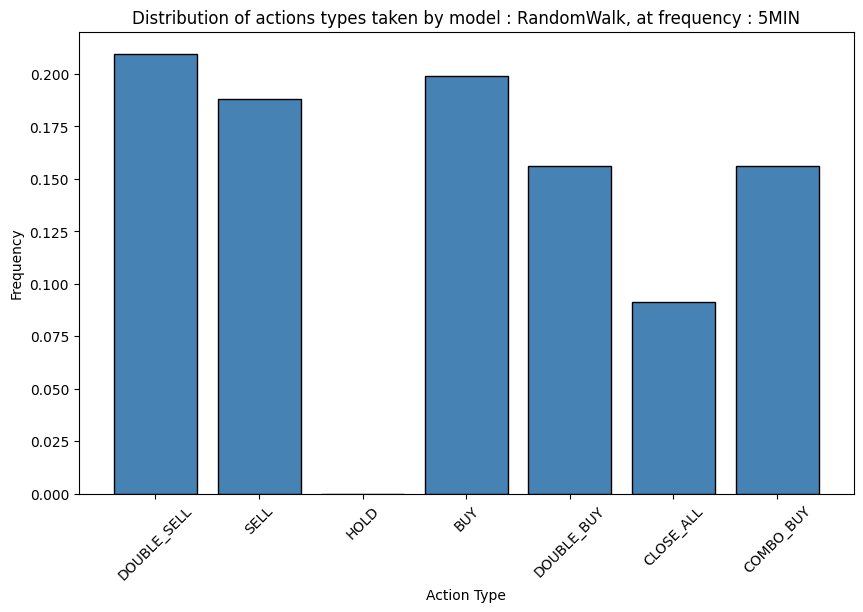

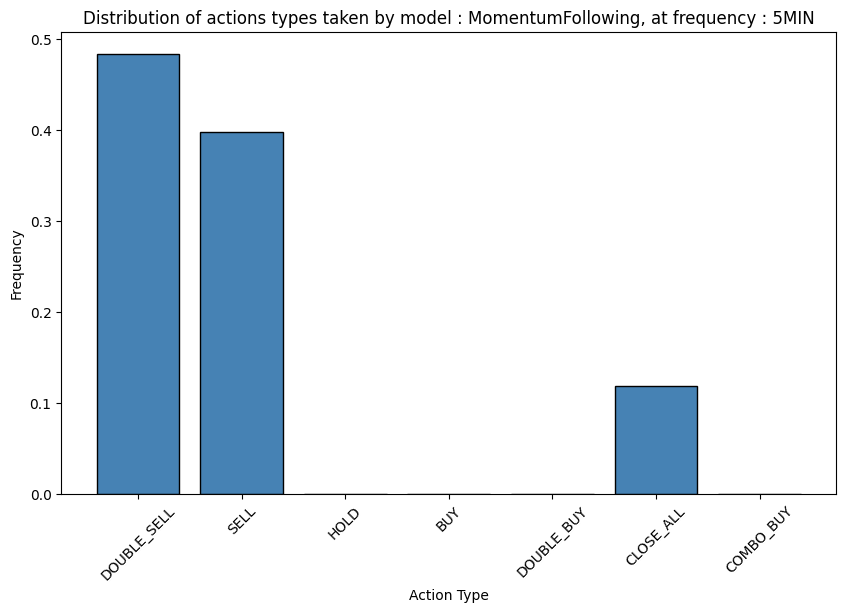

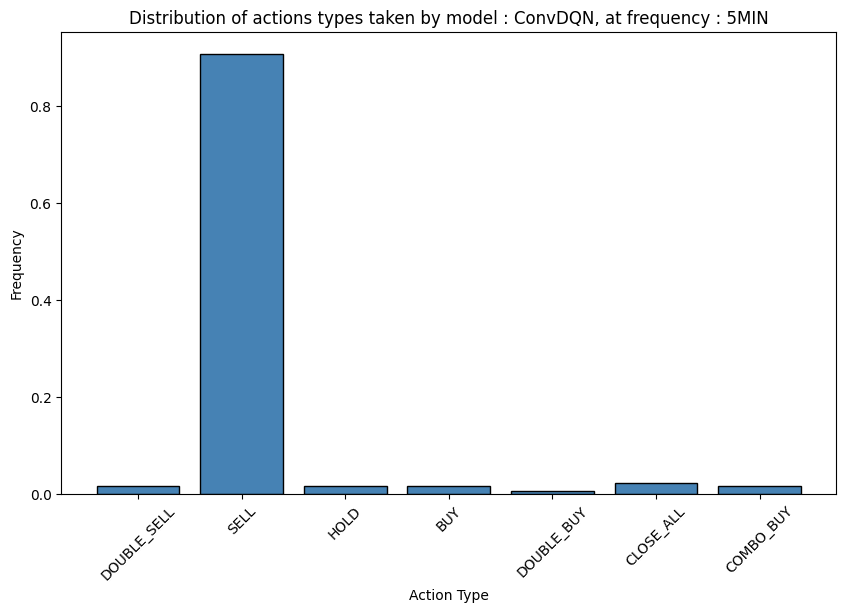

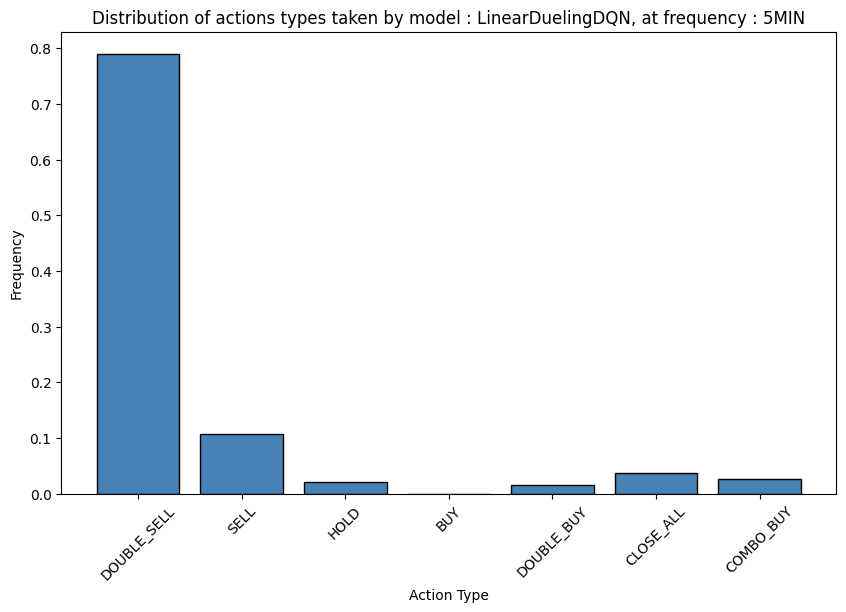

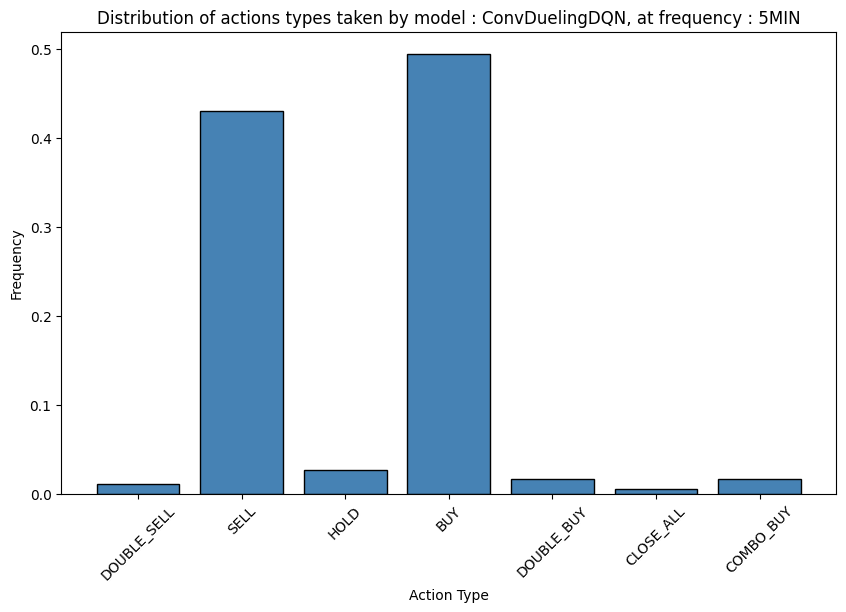

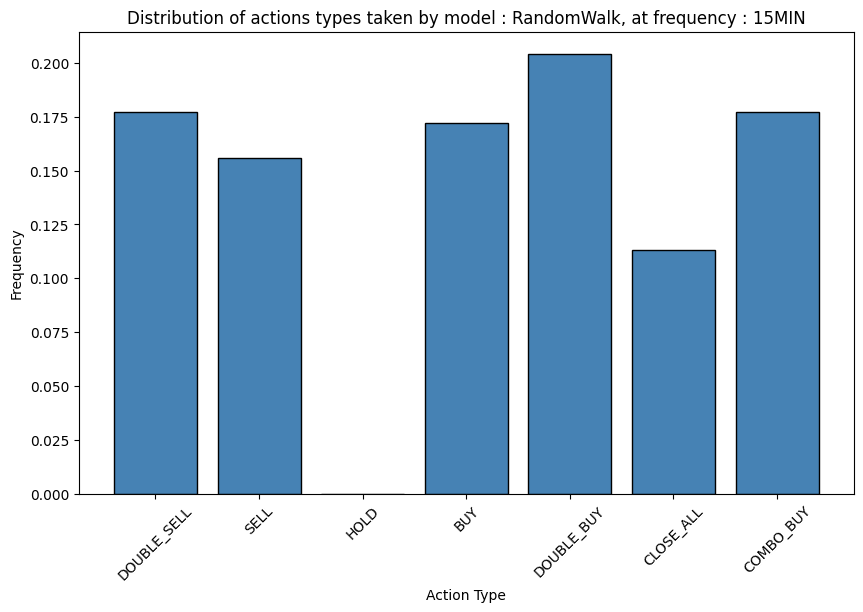

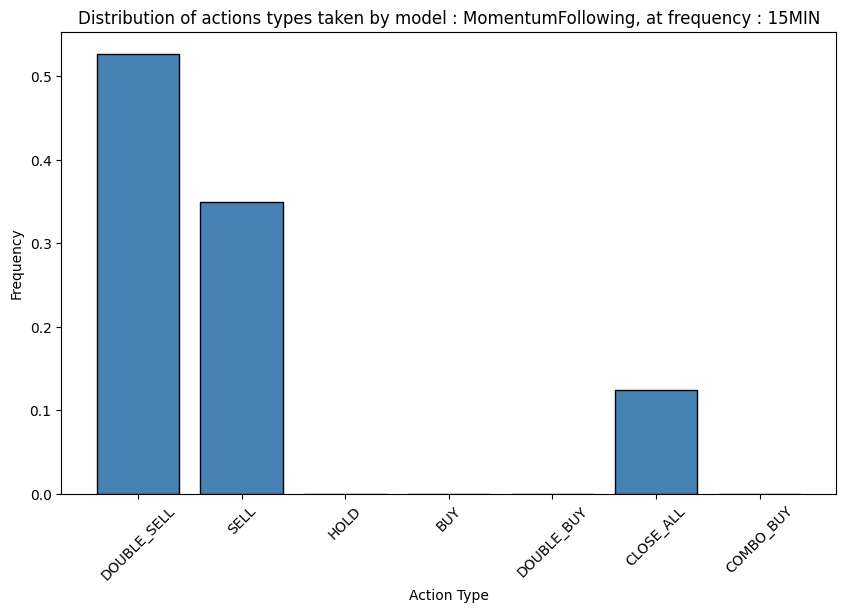

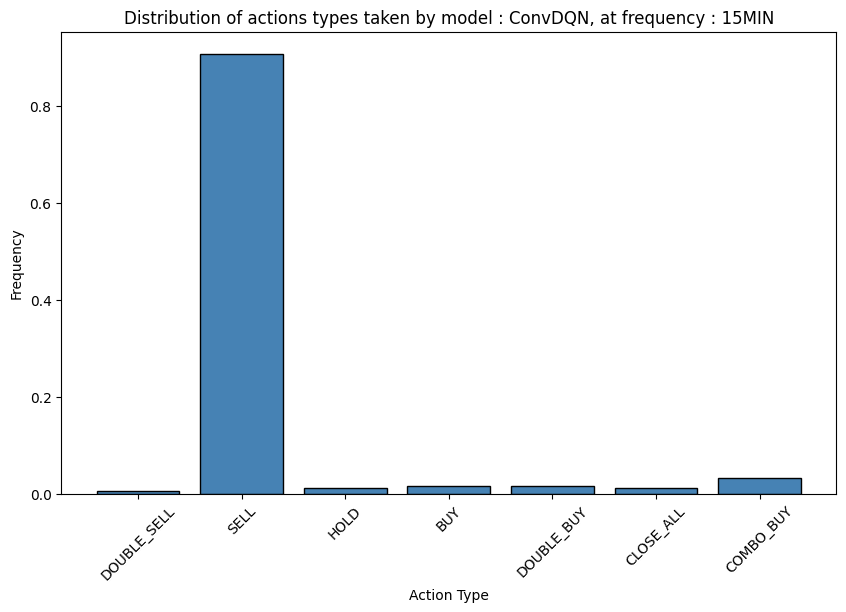

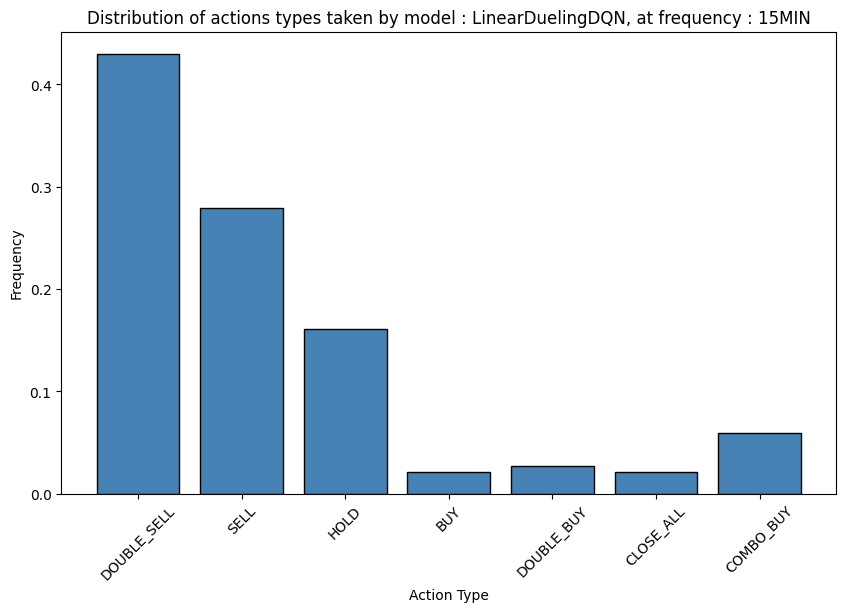

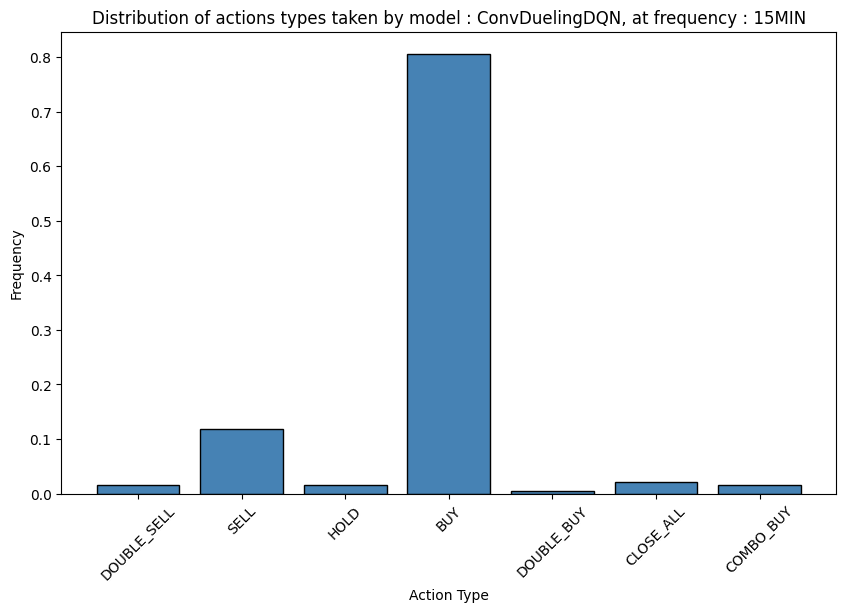

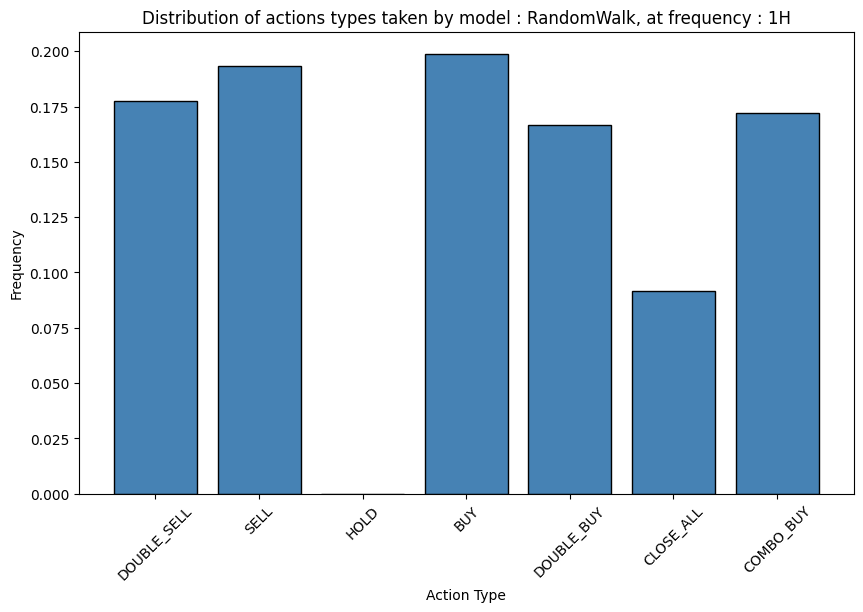

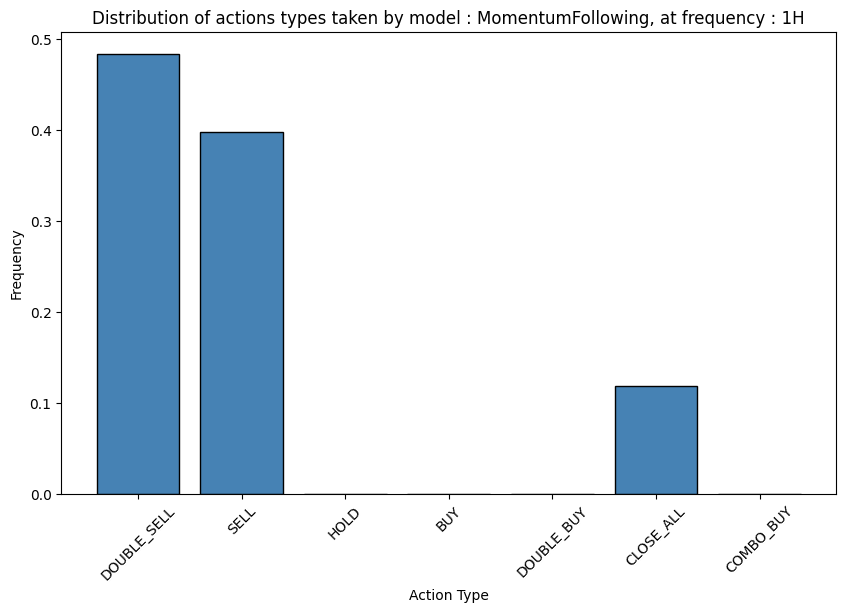

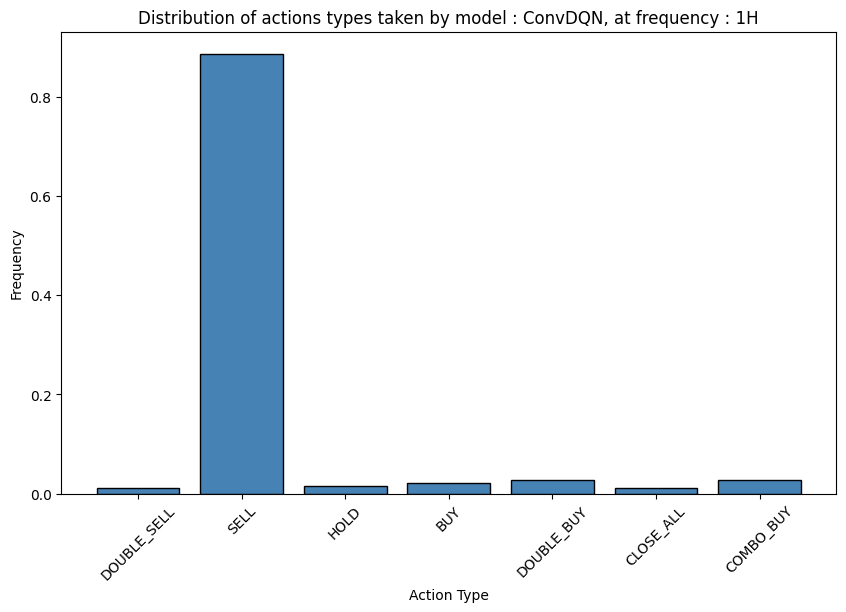

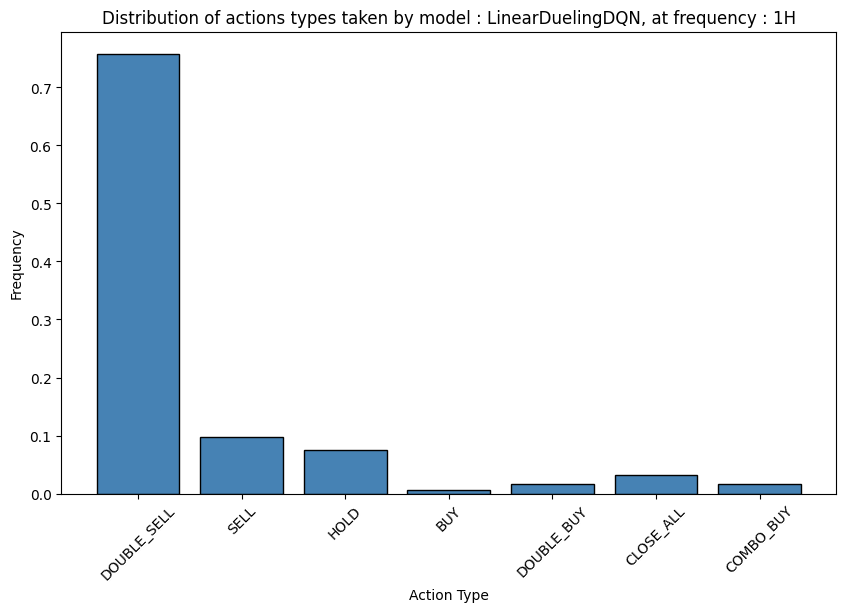

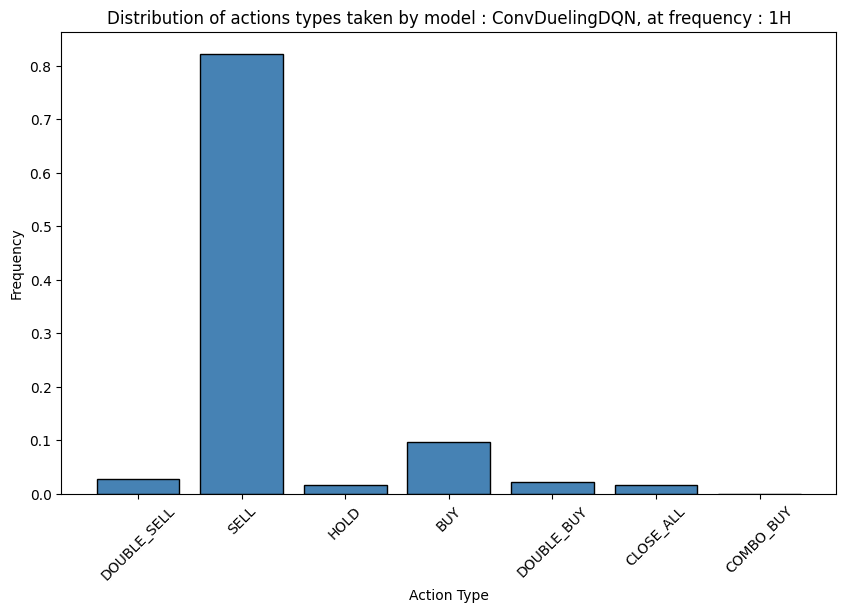

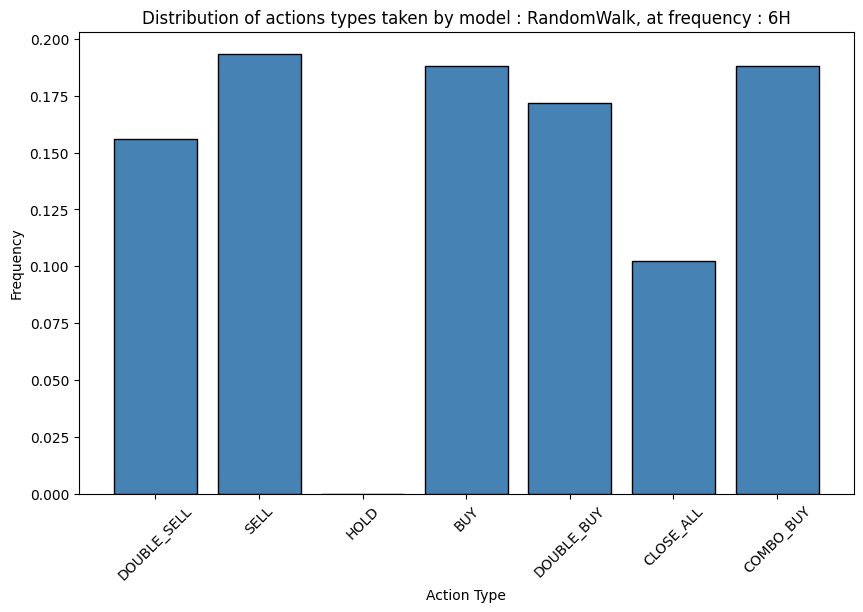

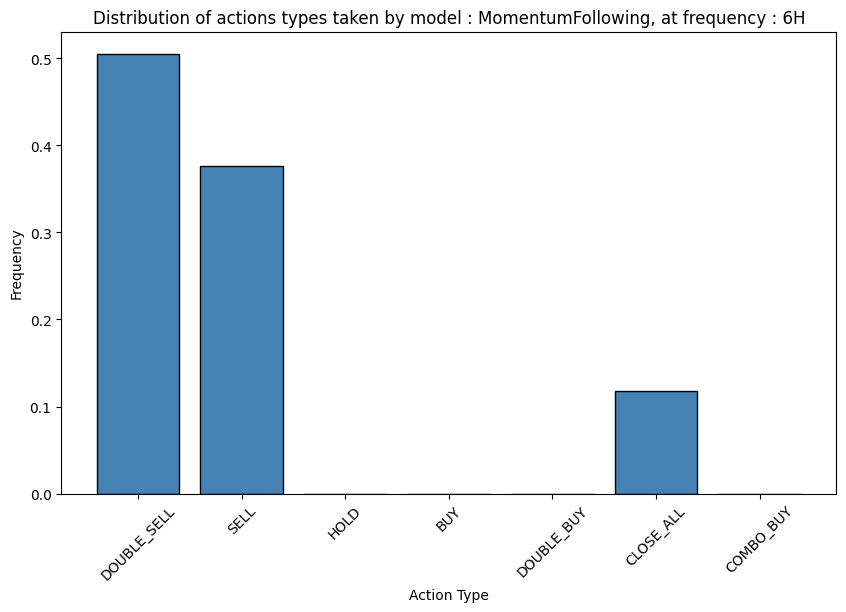

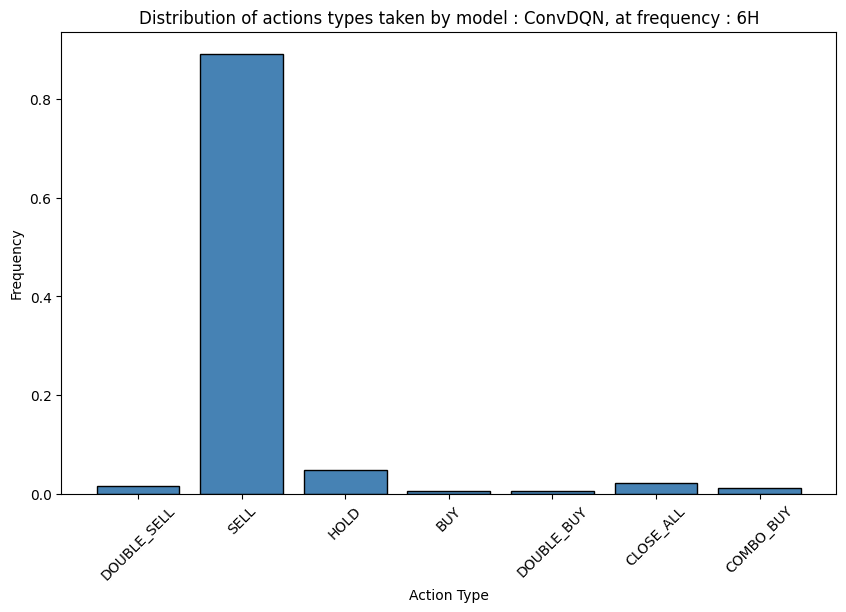

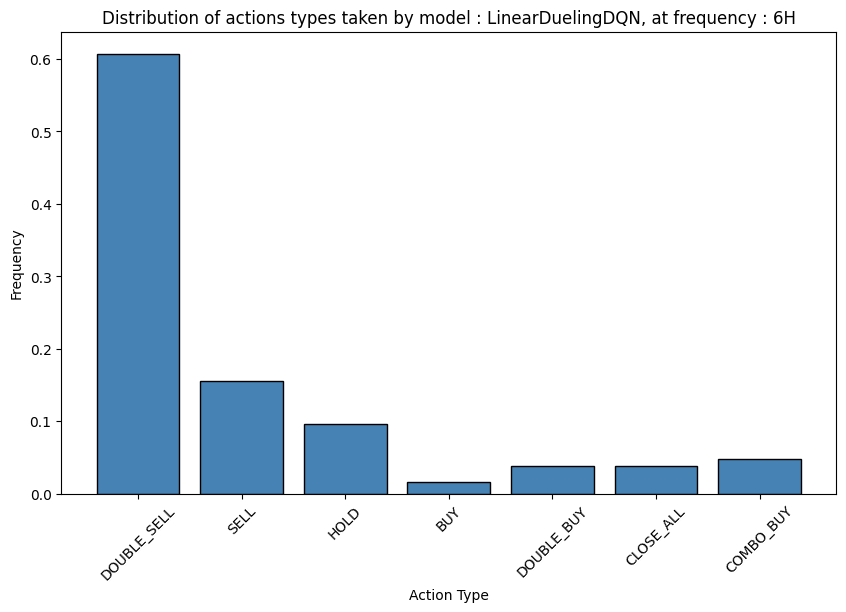

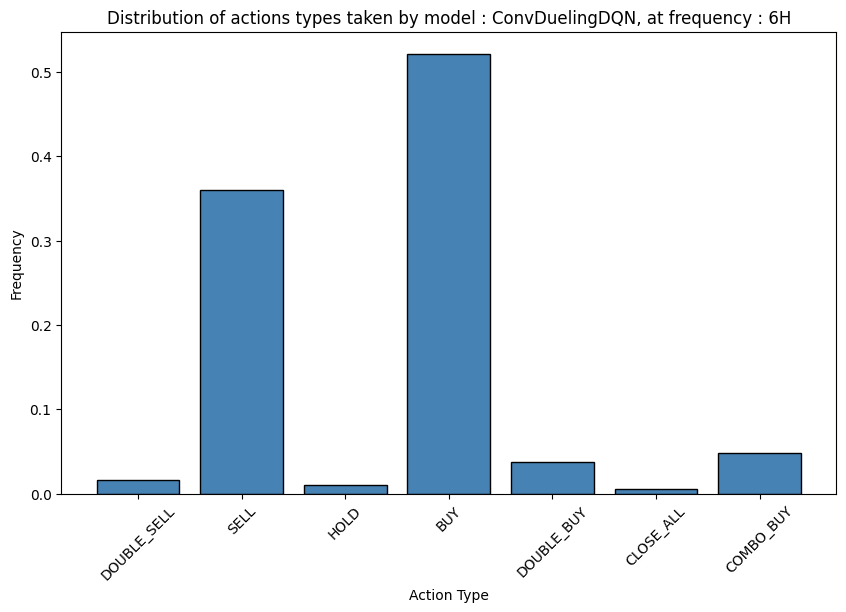

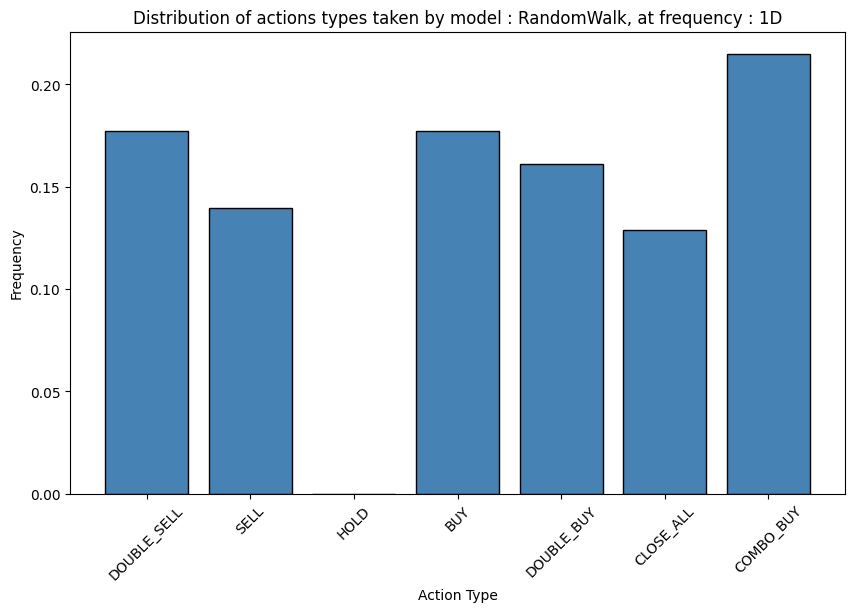

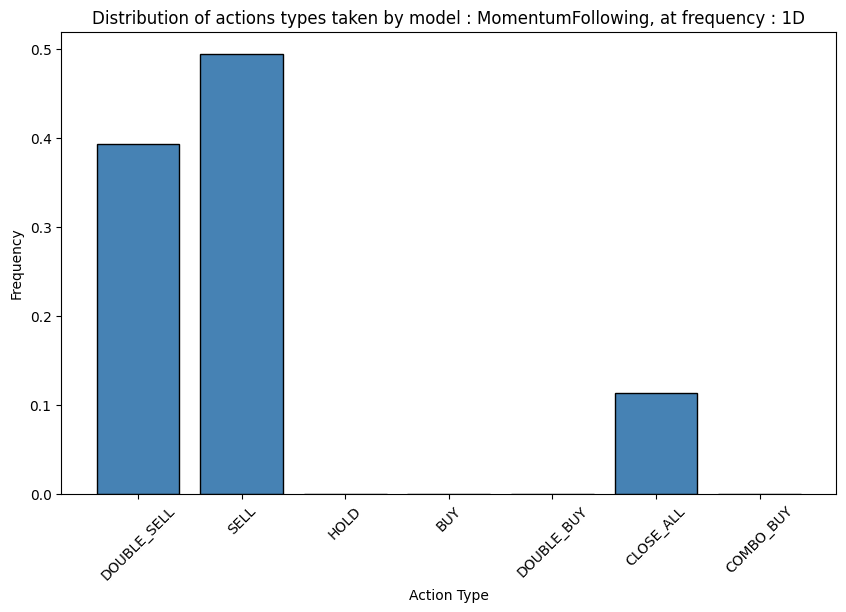

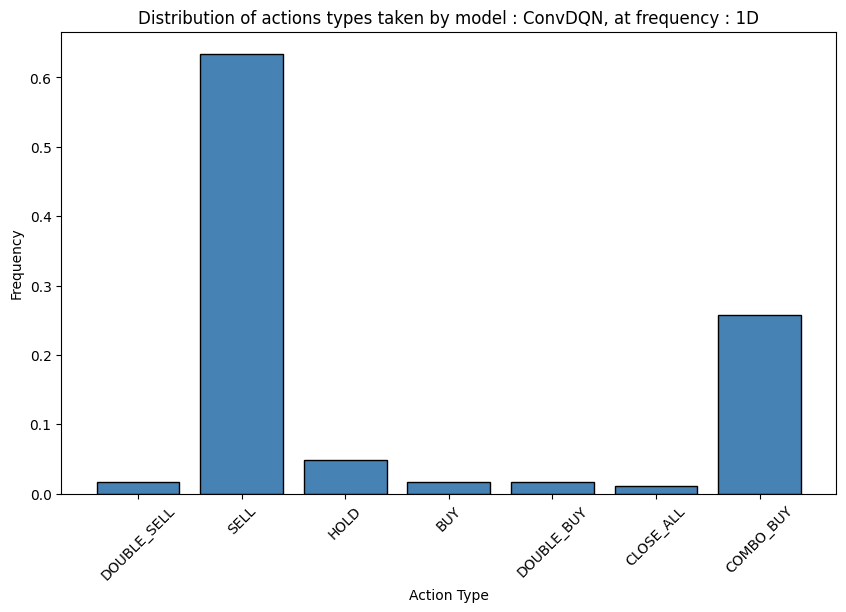

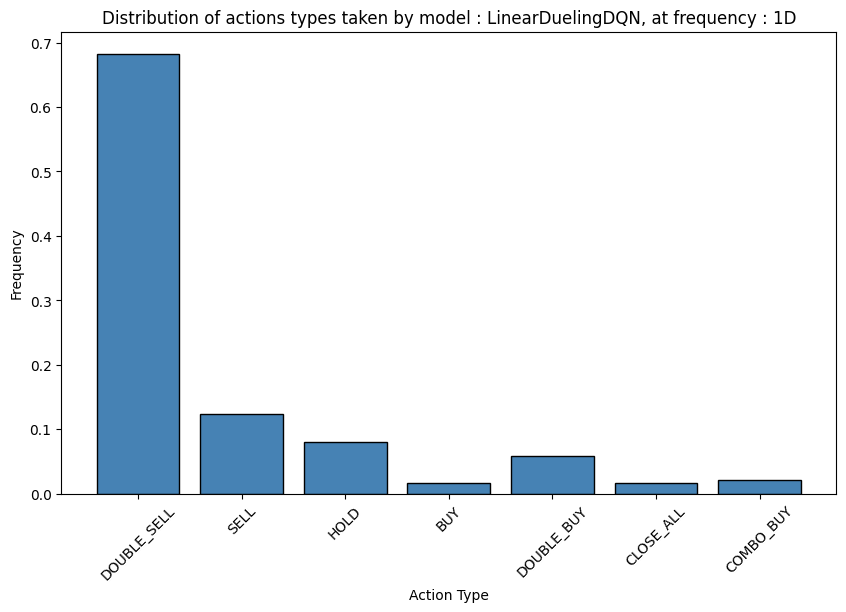

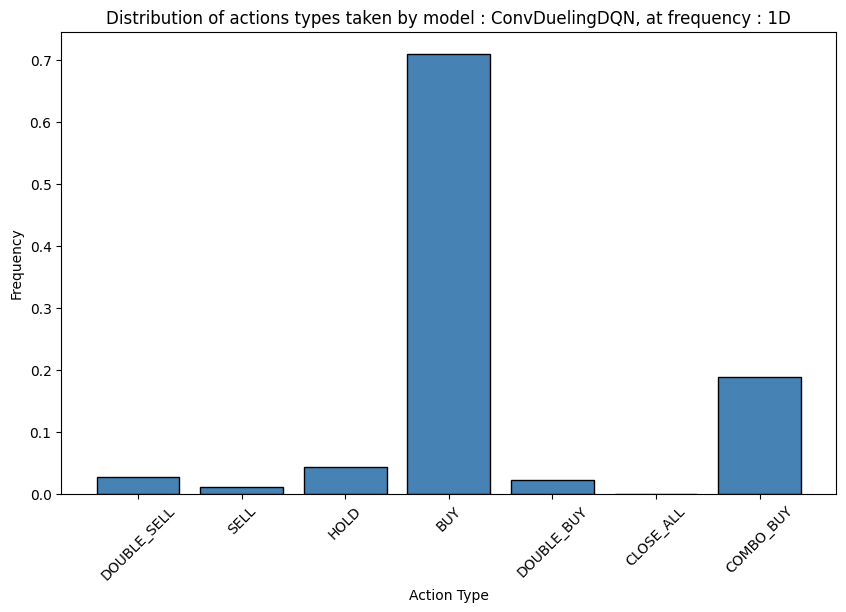

In [180]:
for t in agent_result.time_freqs:
    for model in agent_result.models:
        agent_result.actions_hist(t, model)

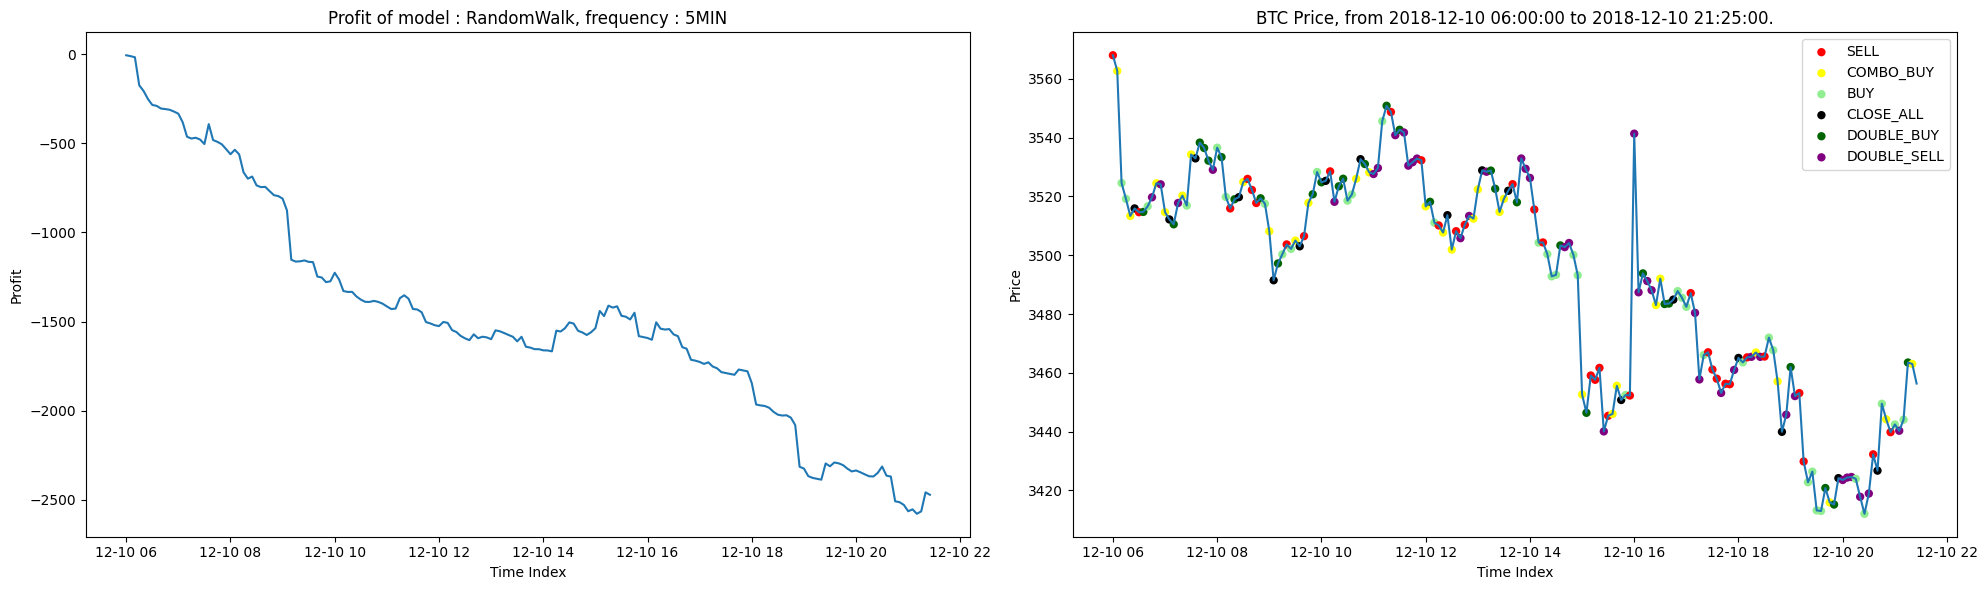

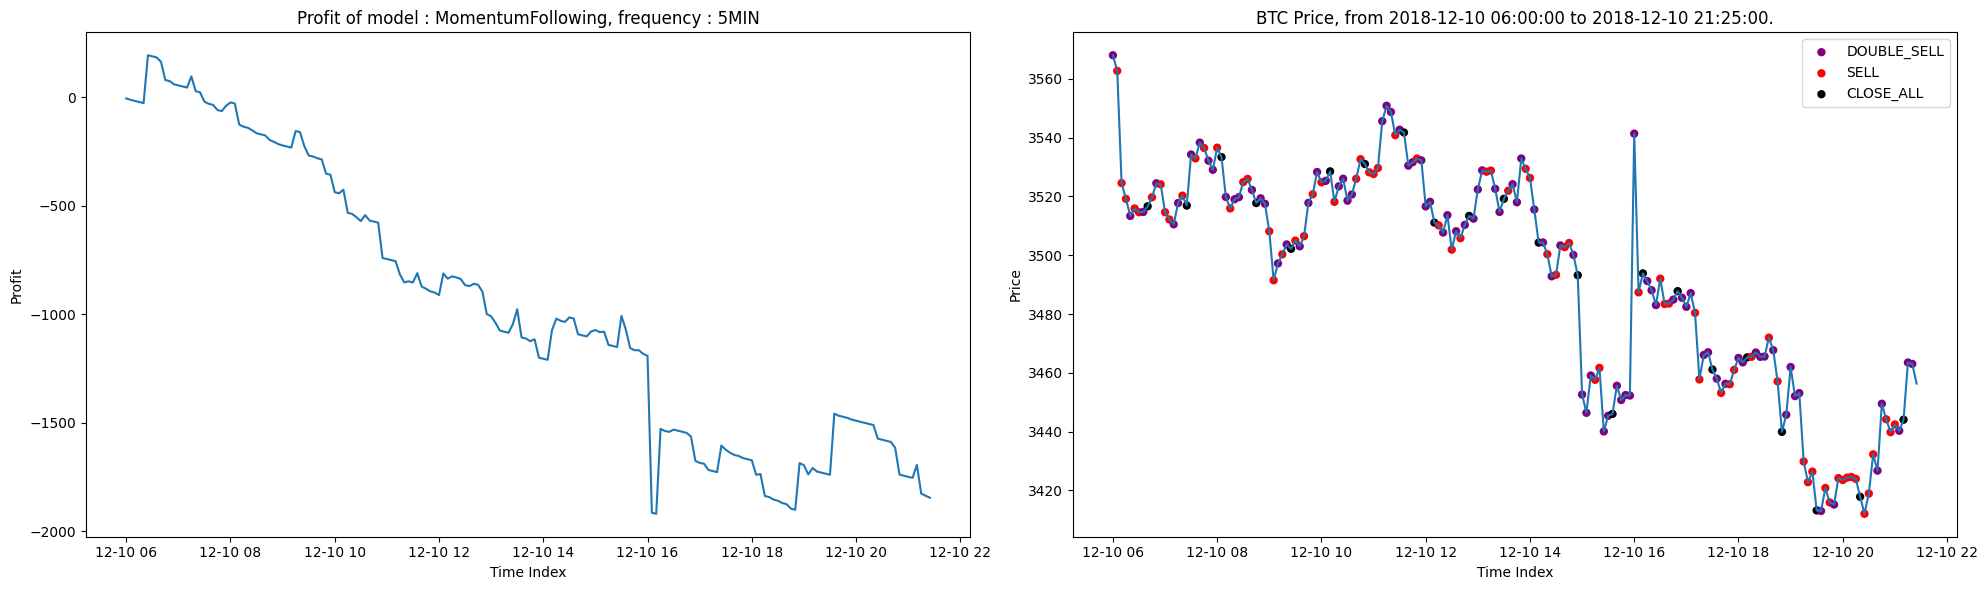

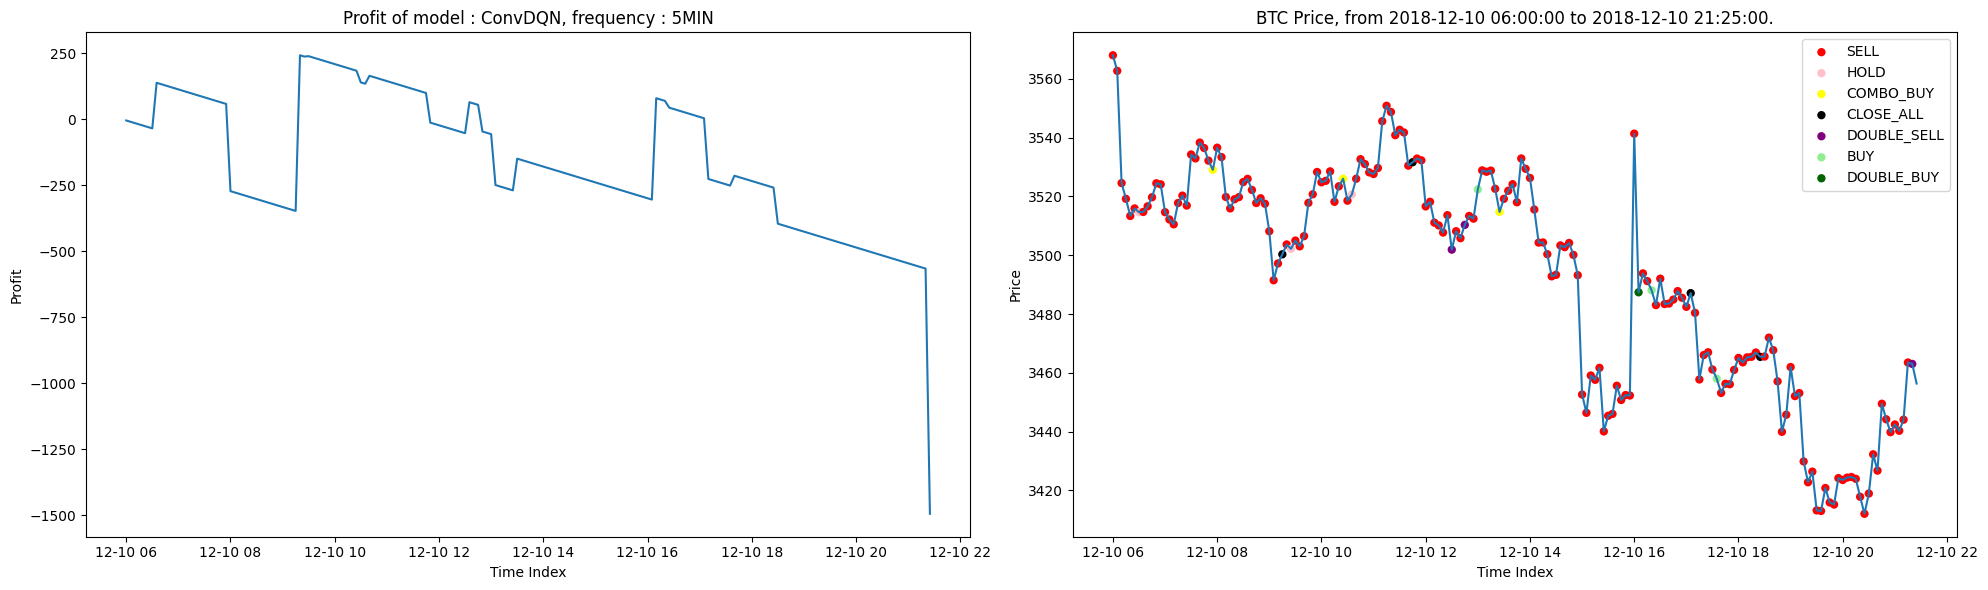

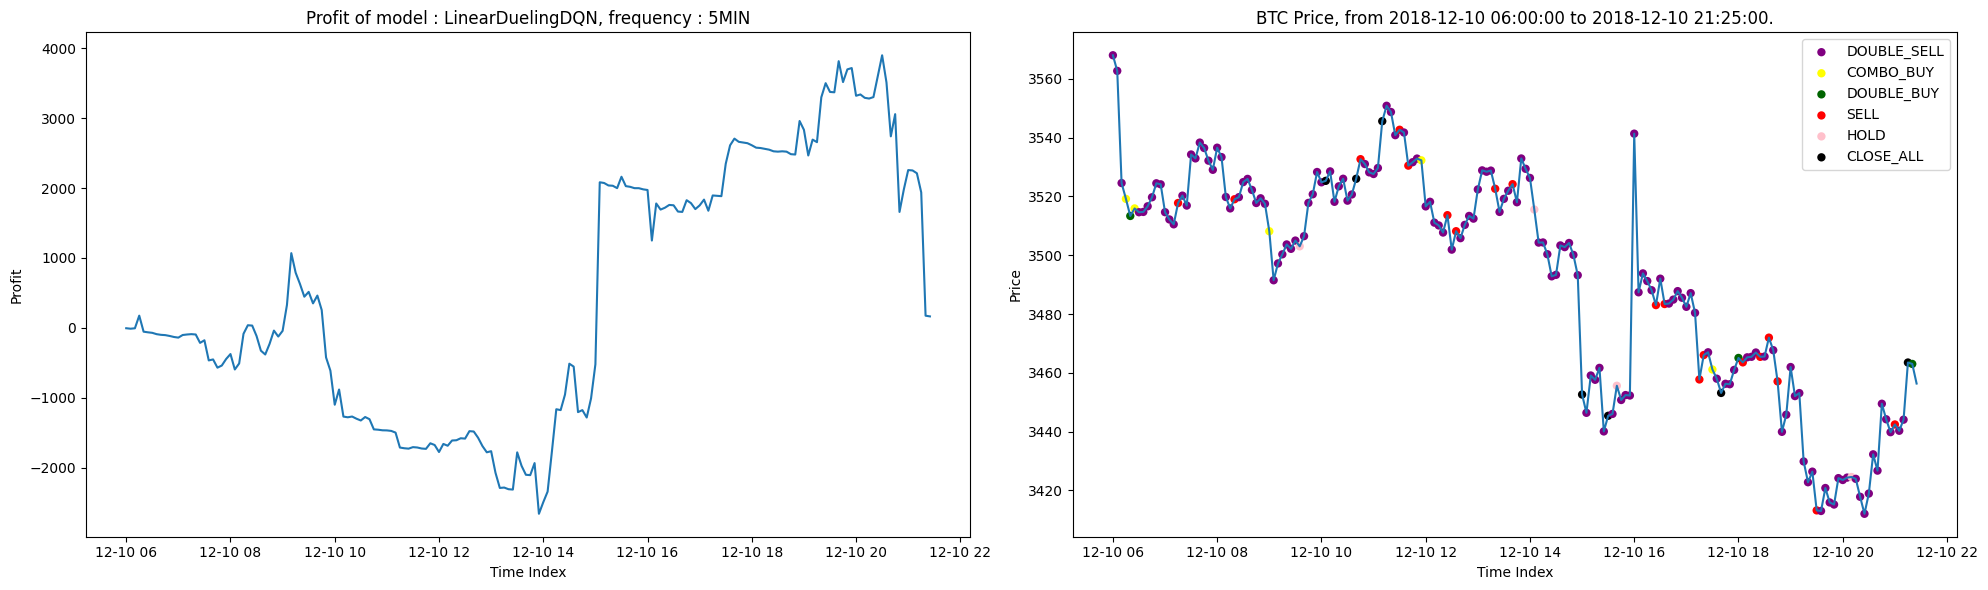

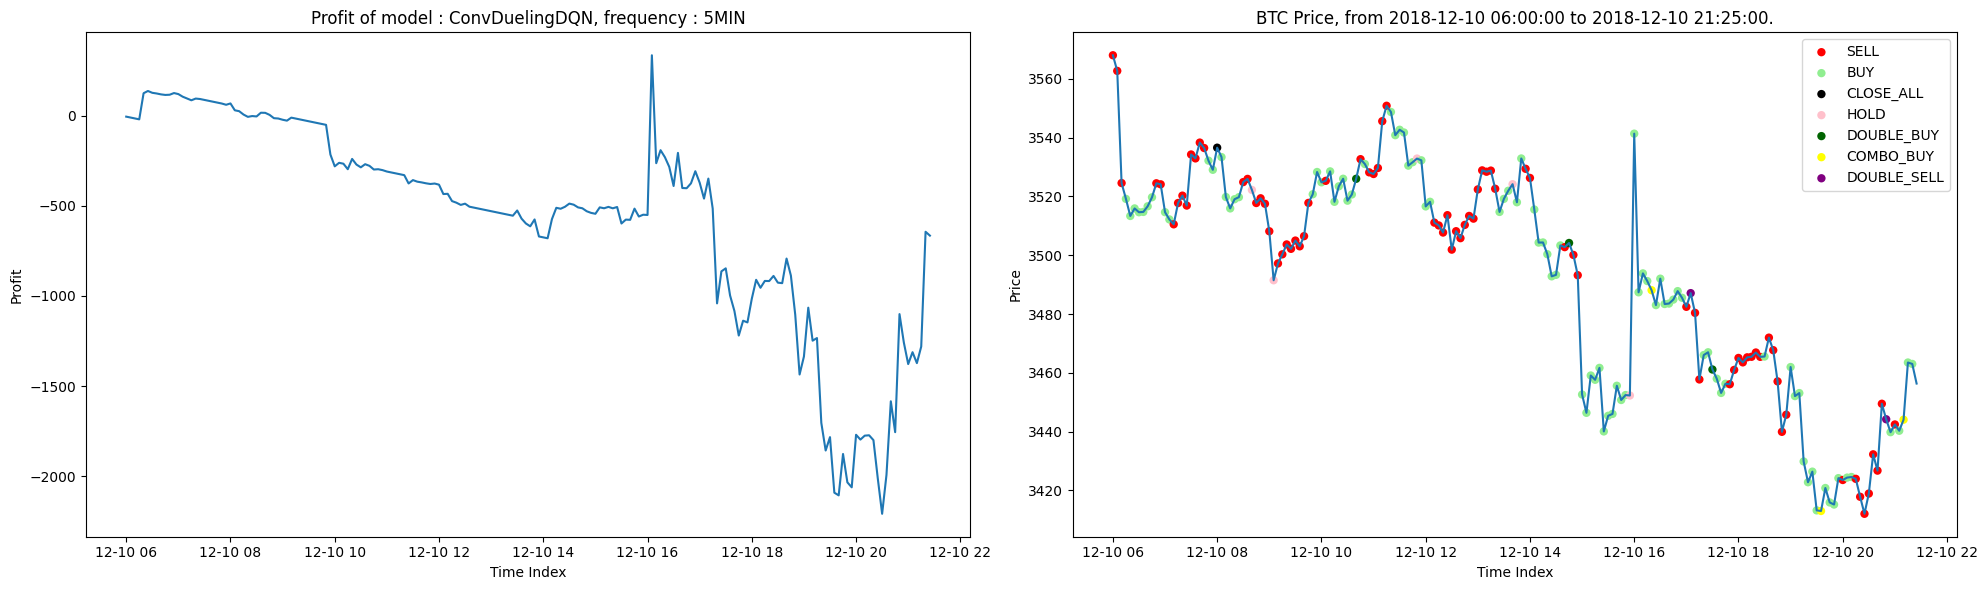

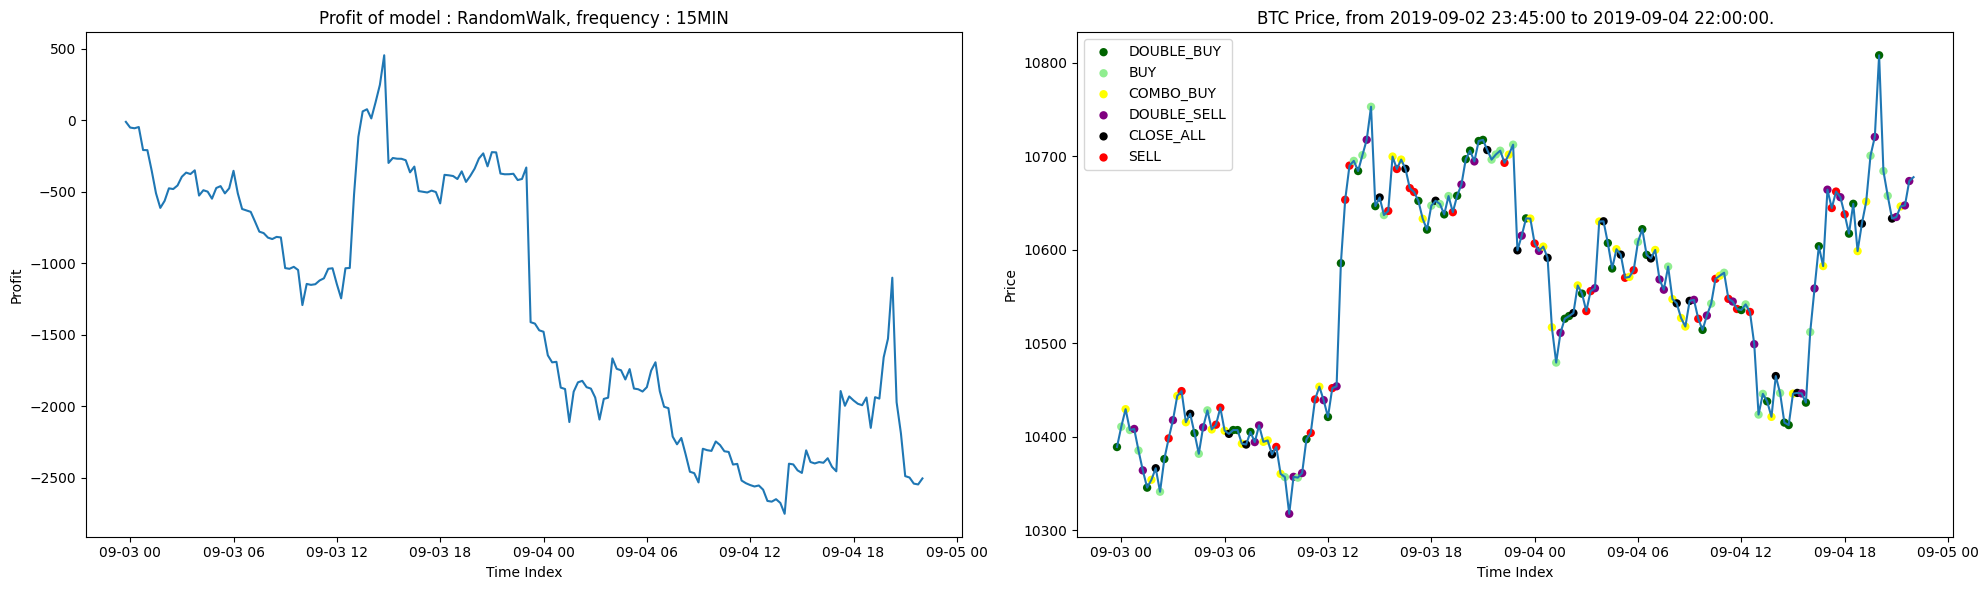

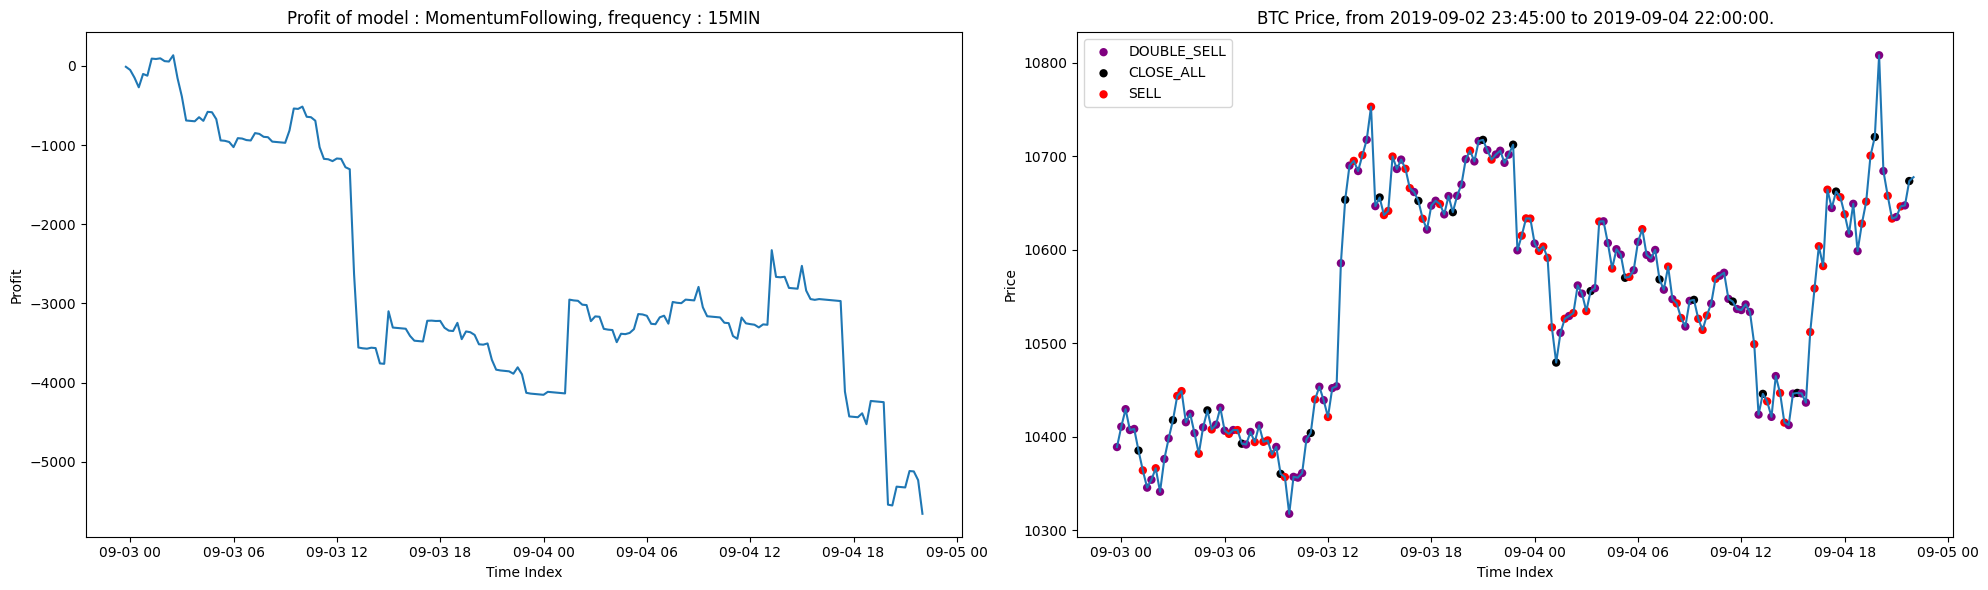

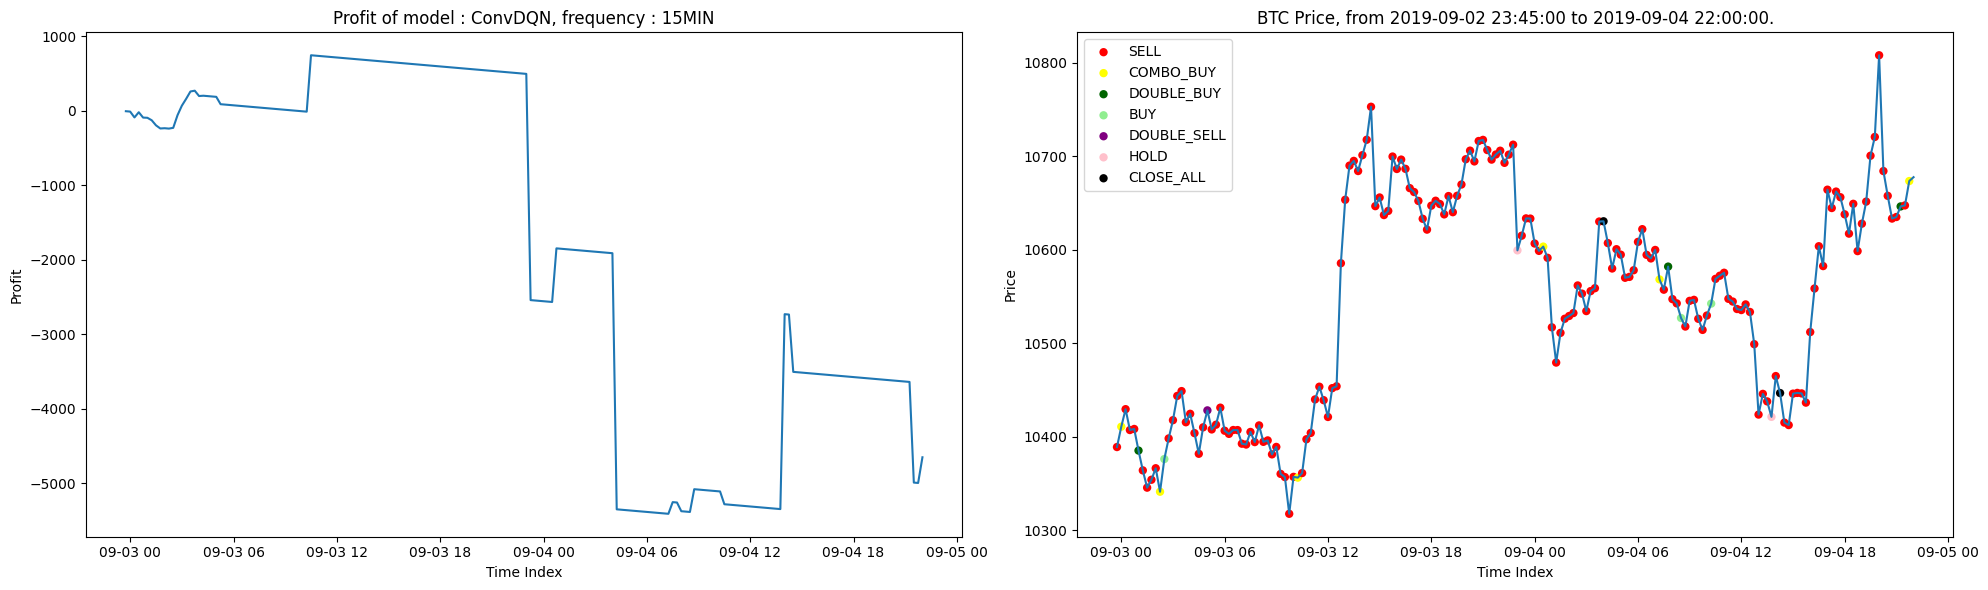

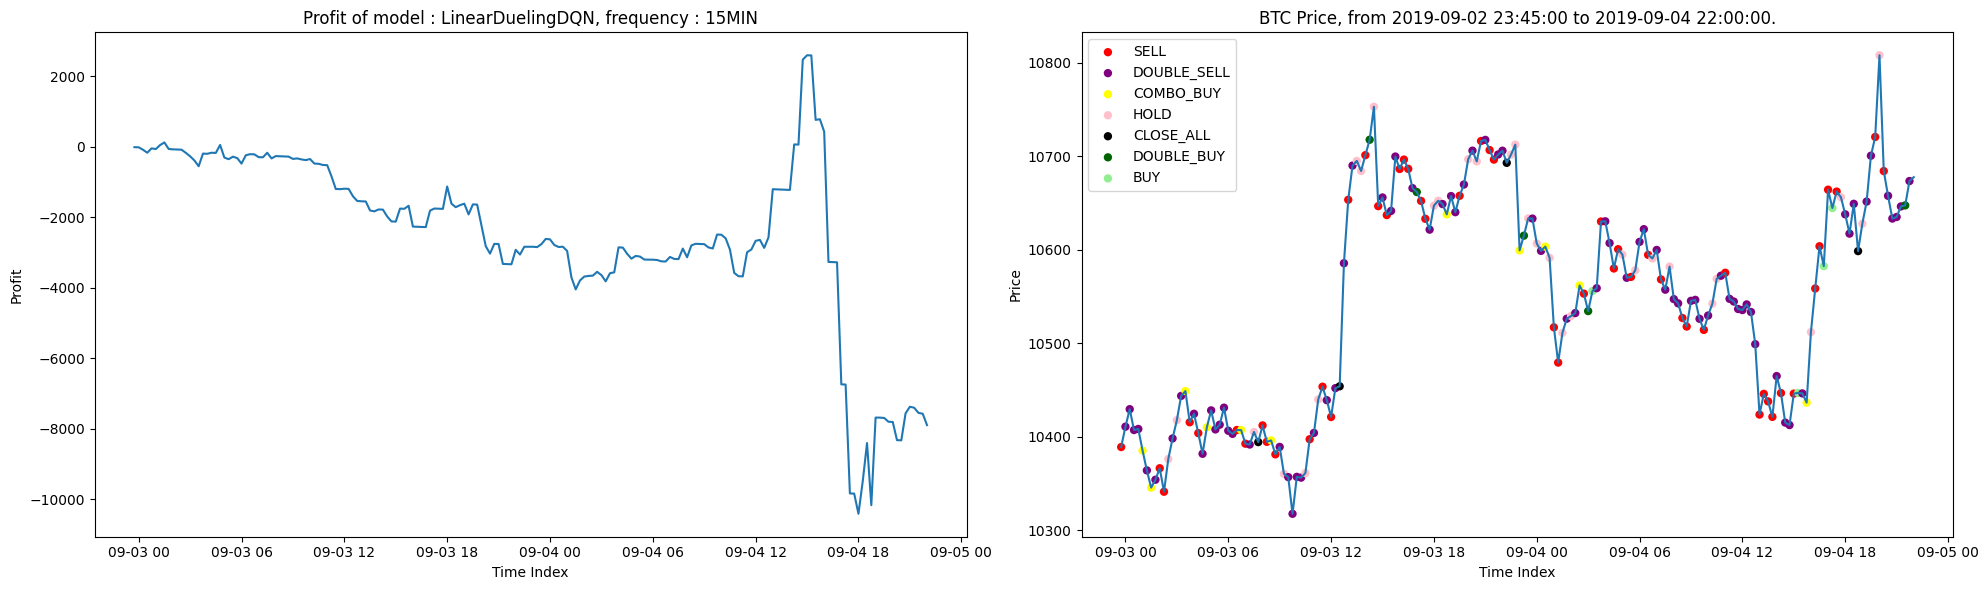

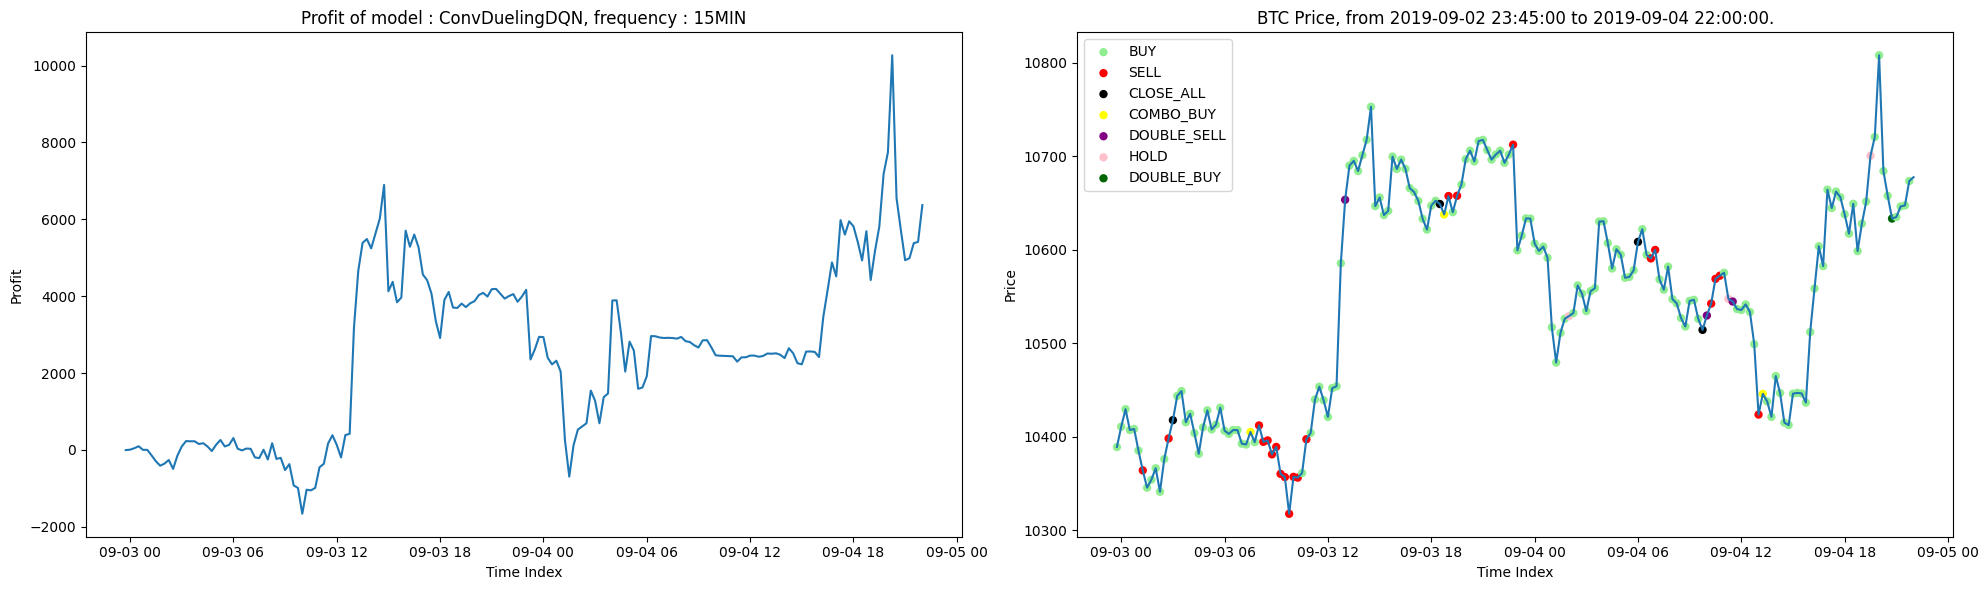

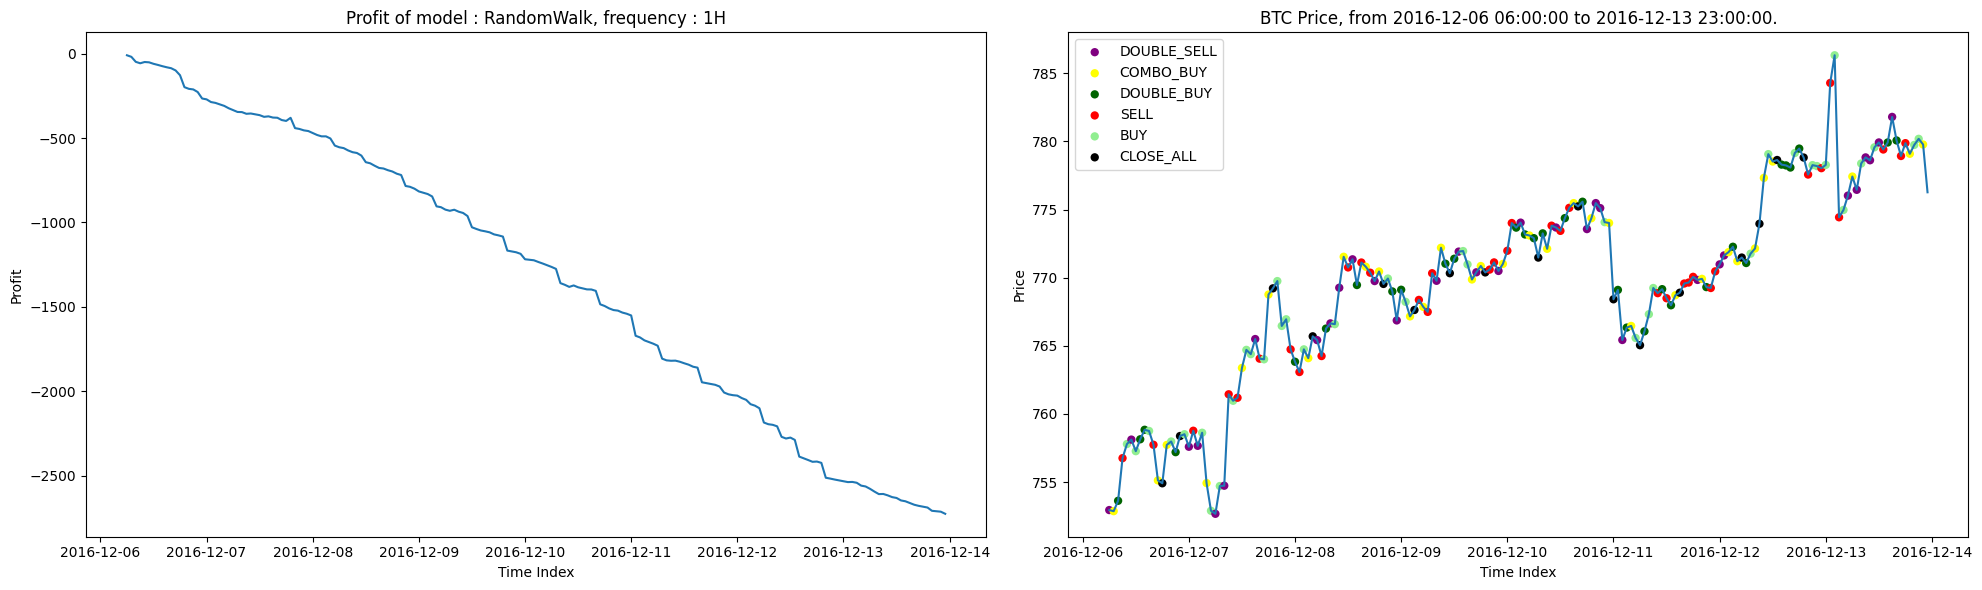

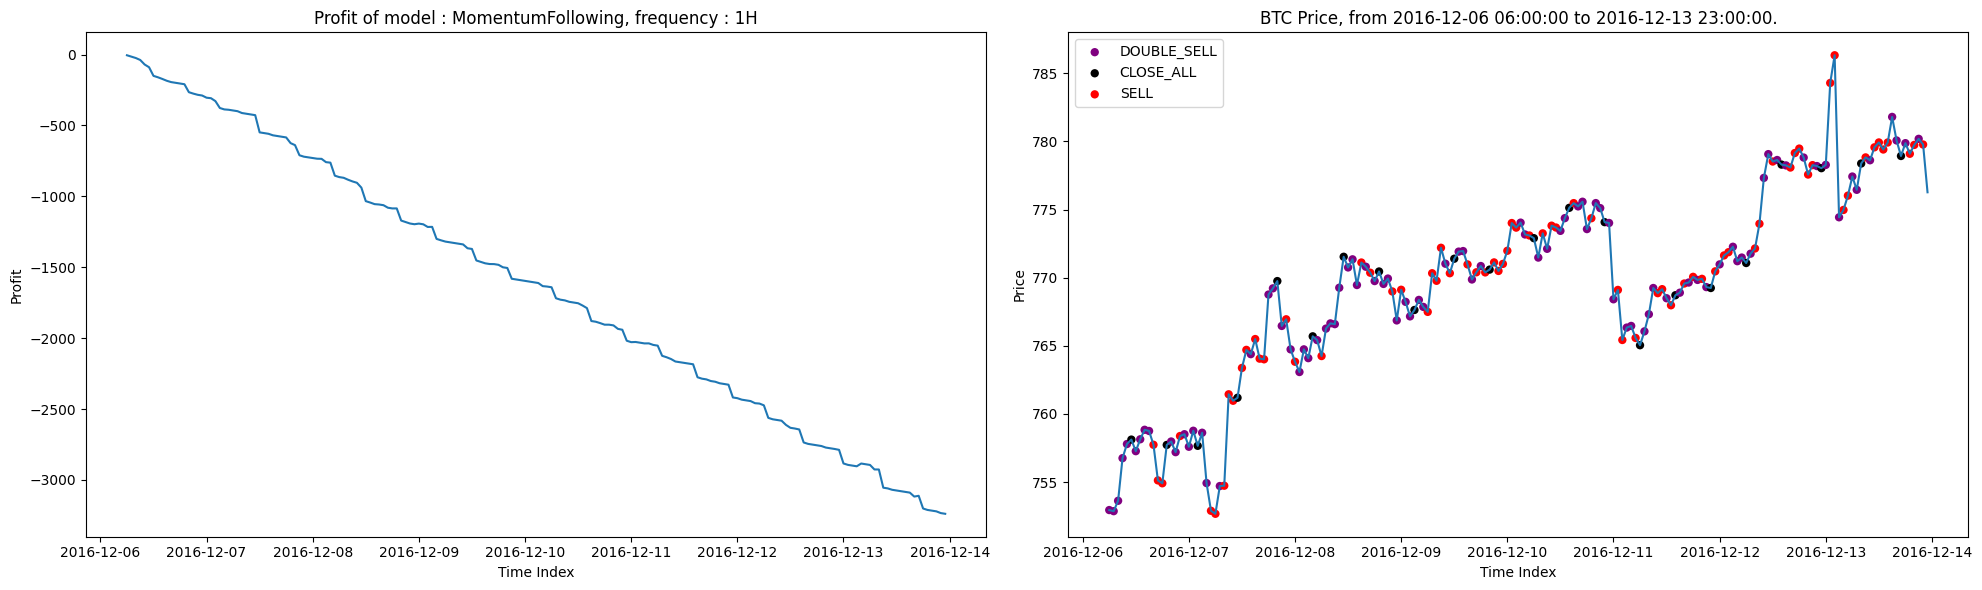

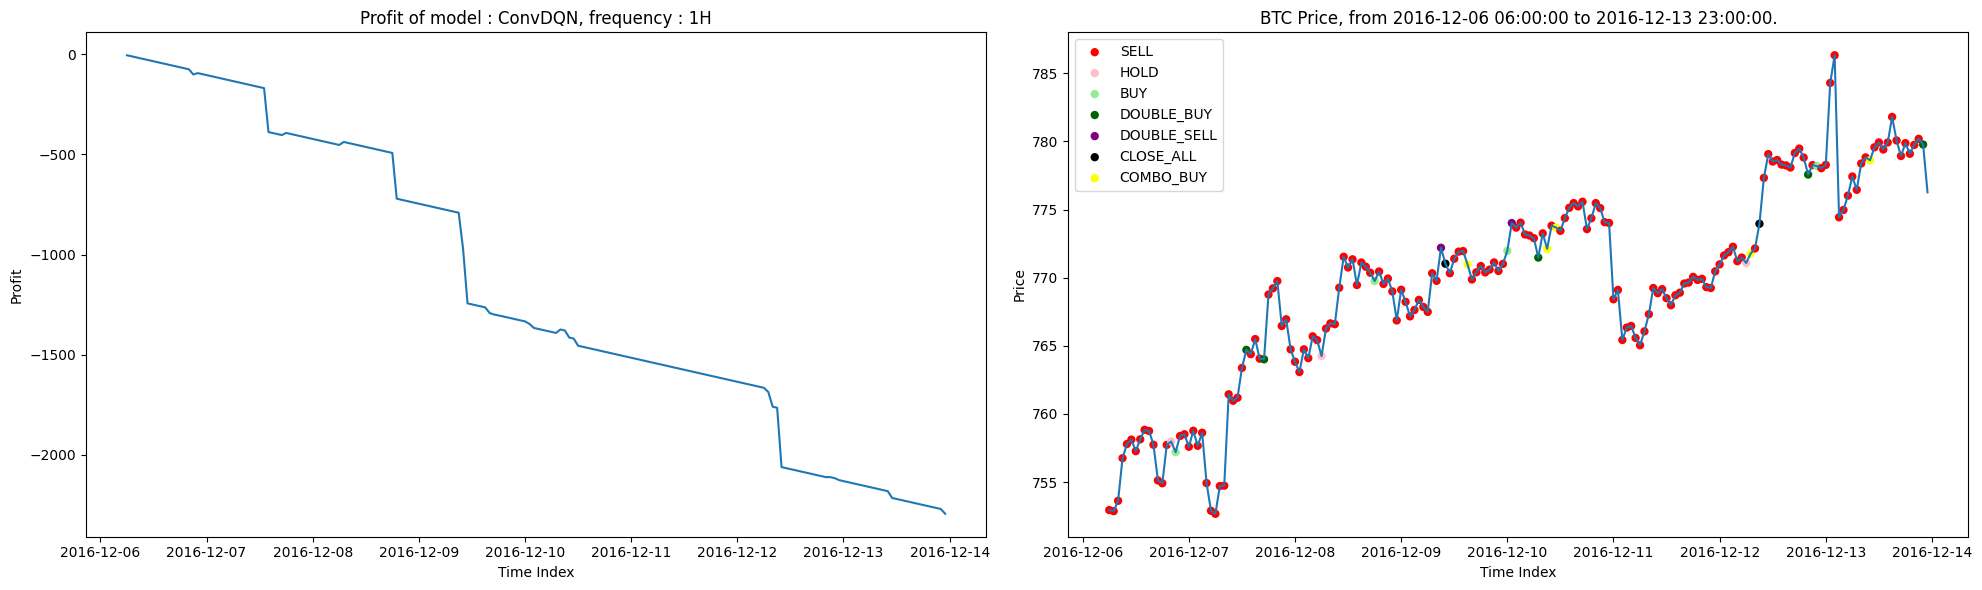

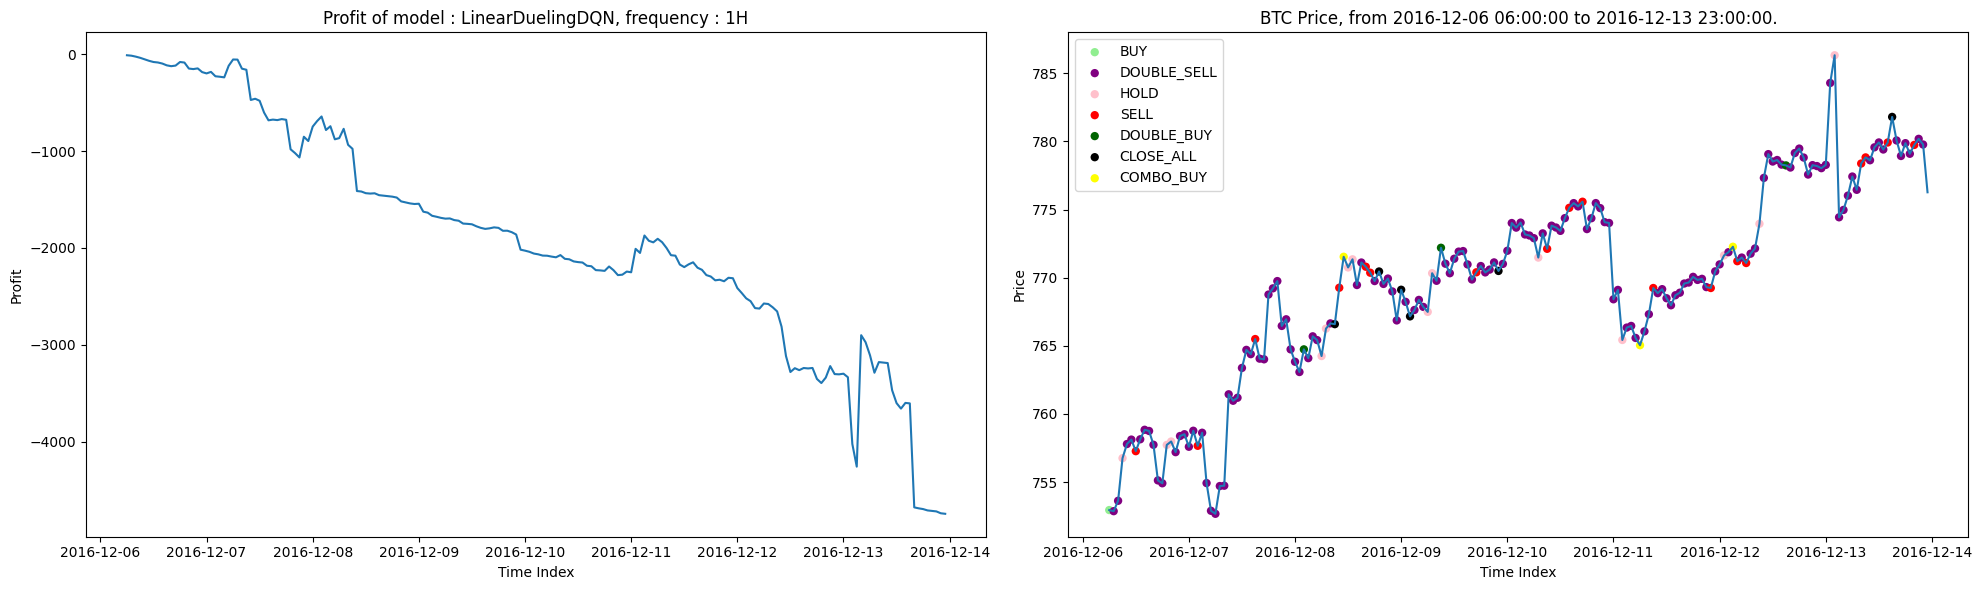

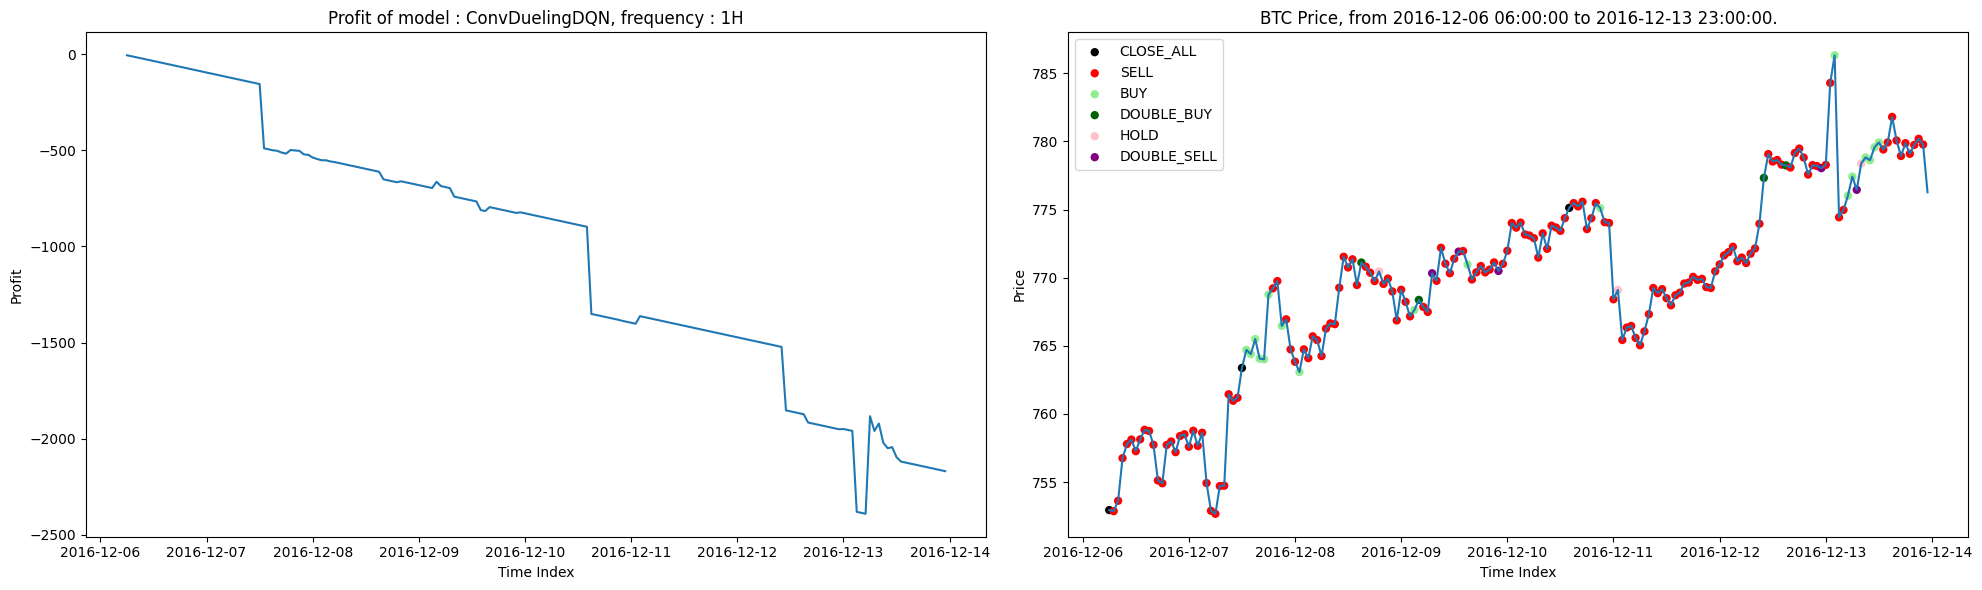

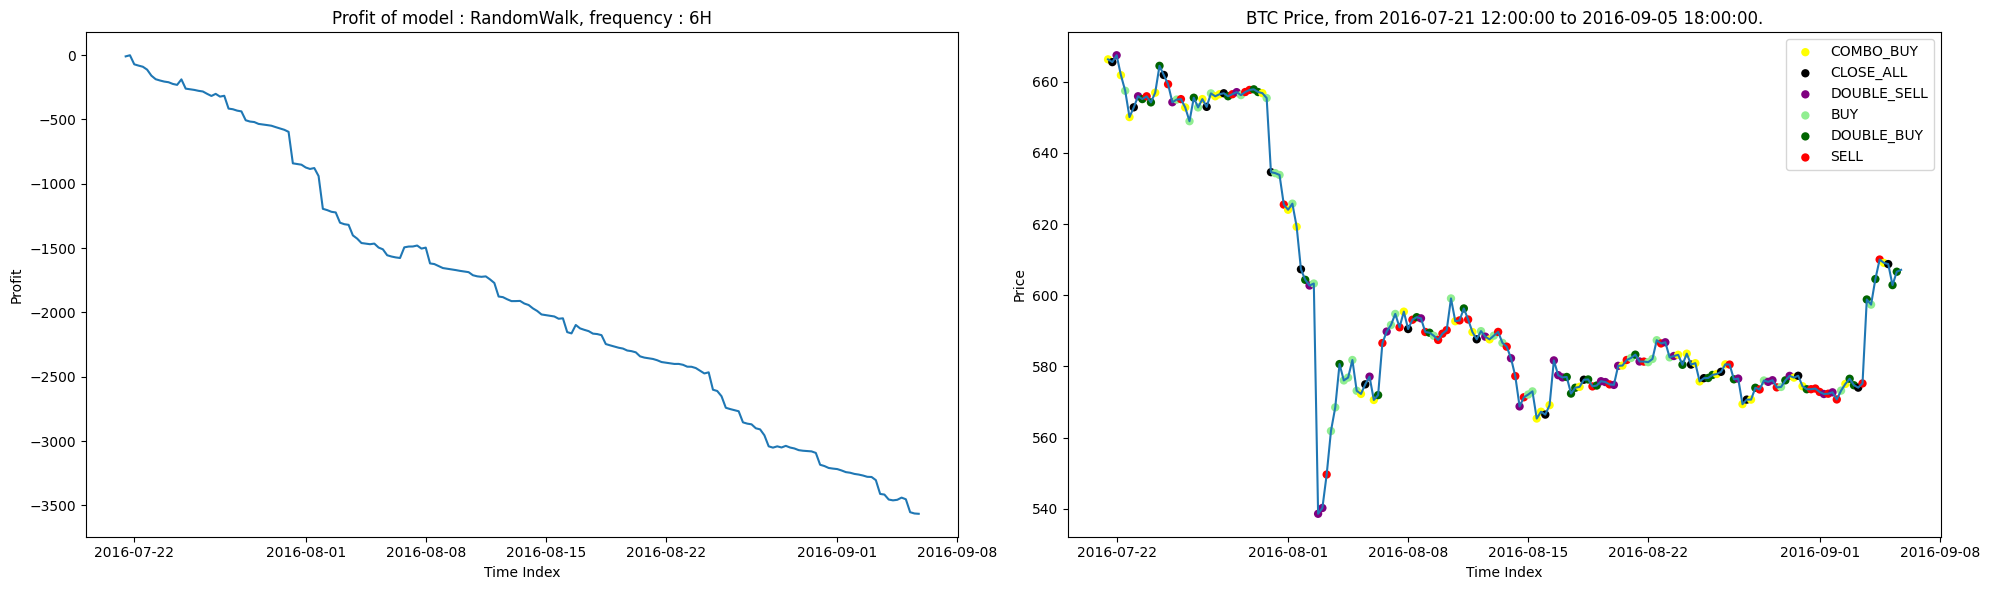

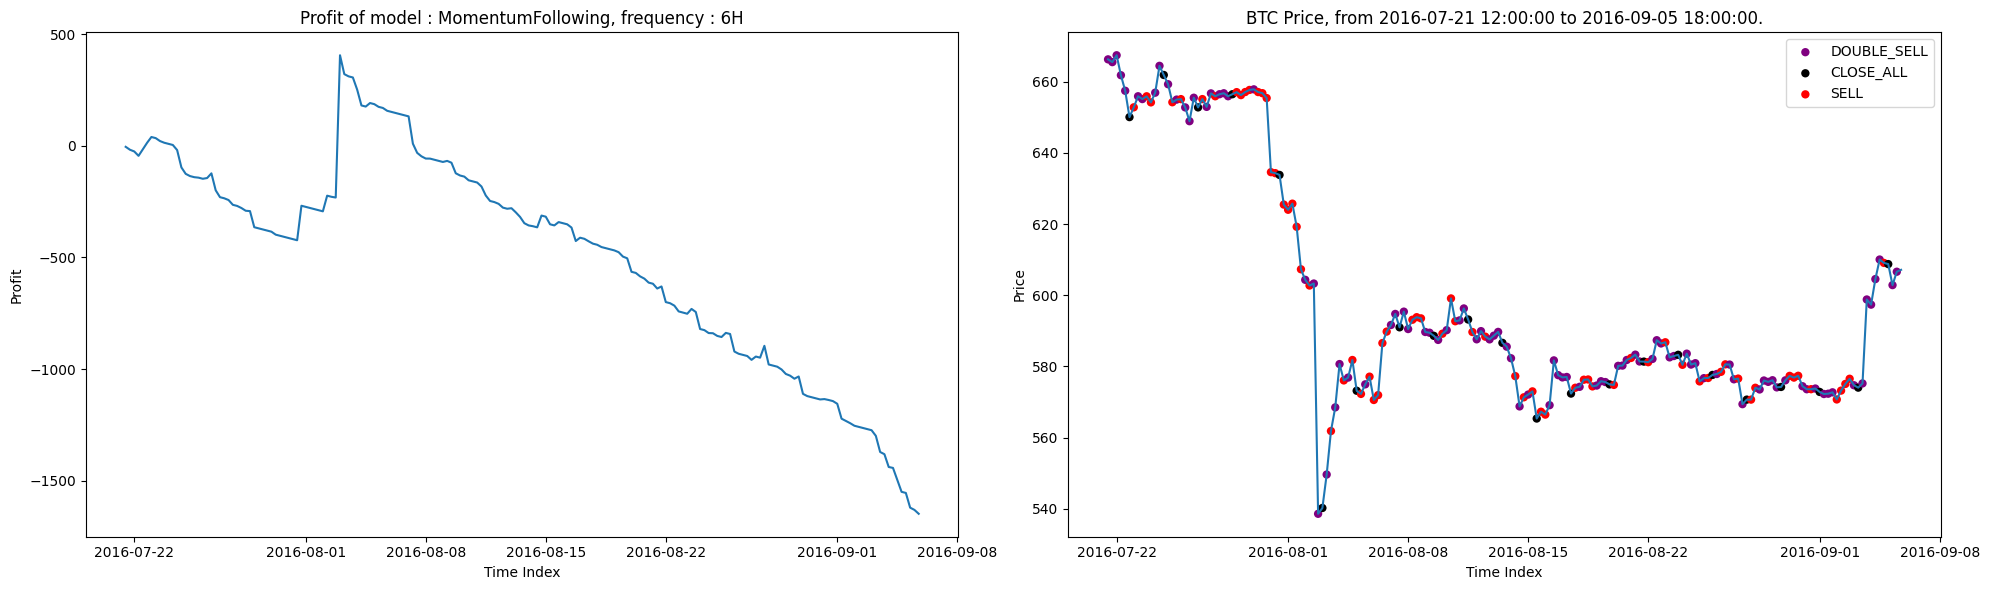

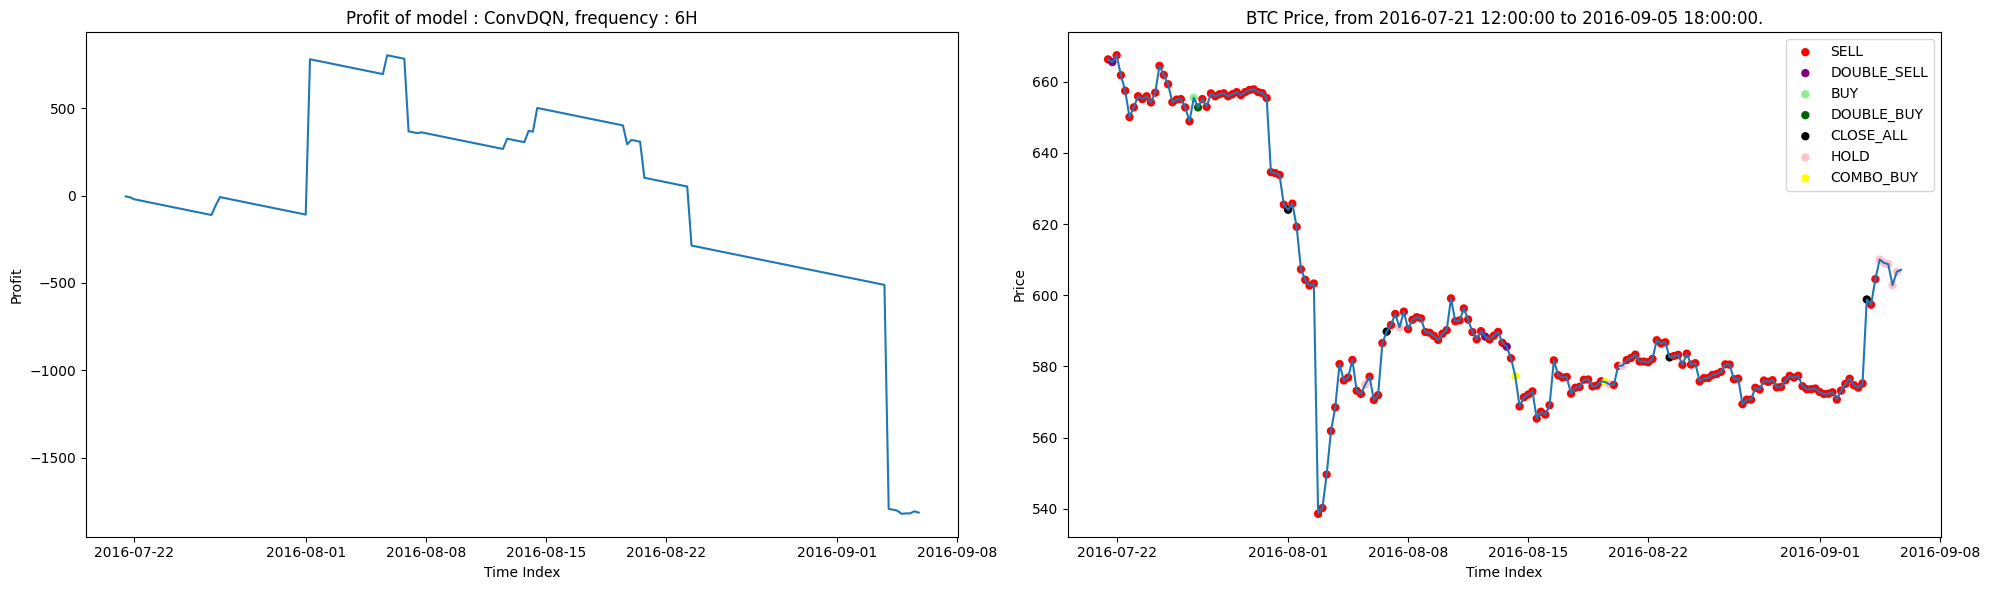

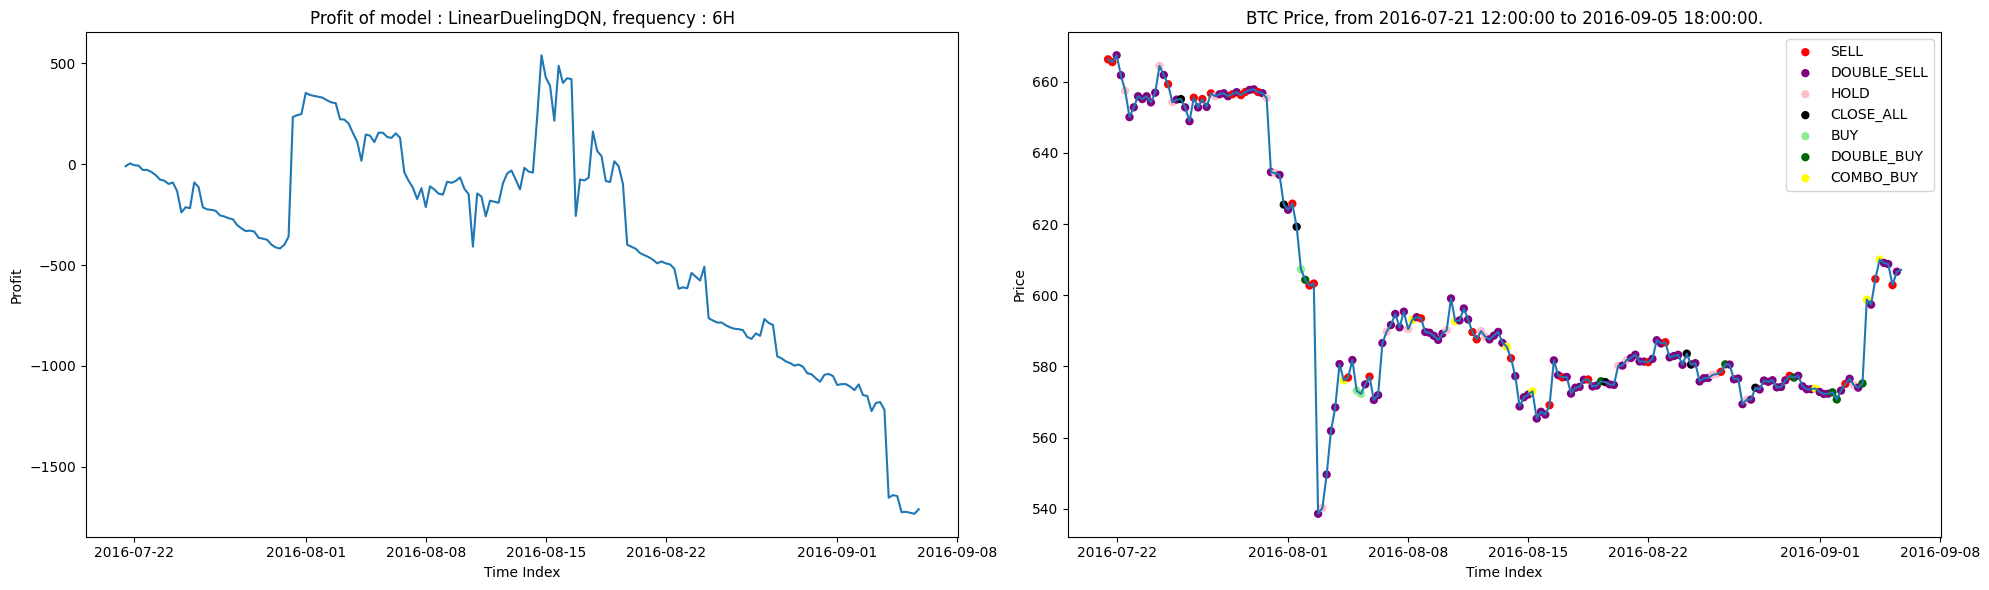

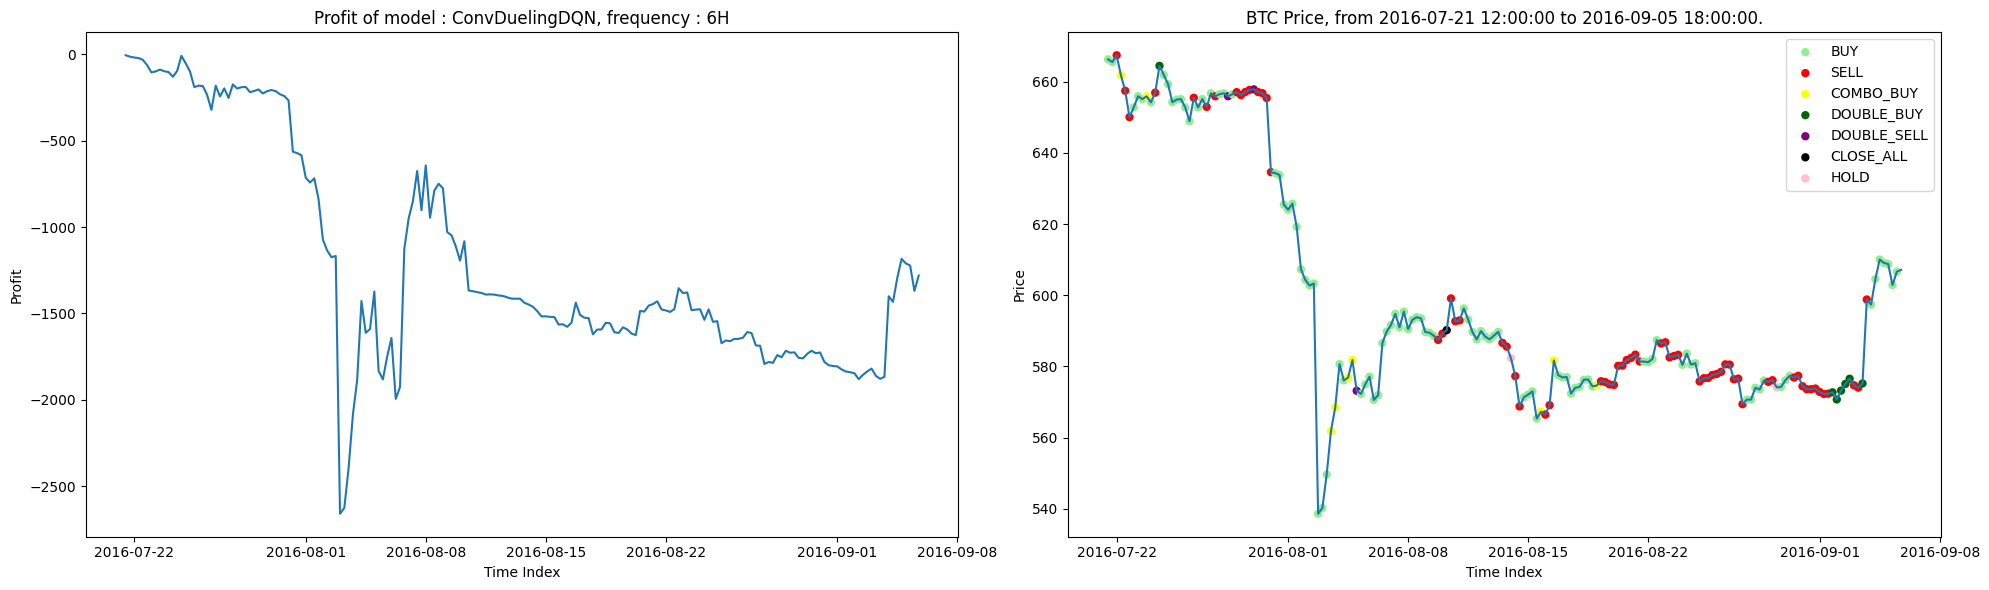

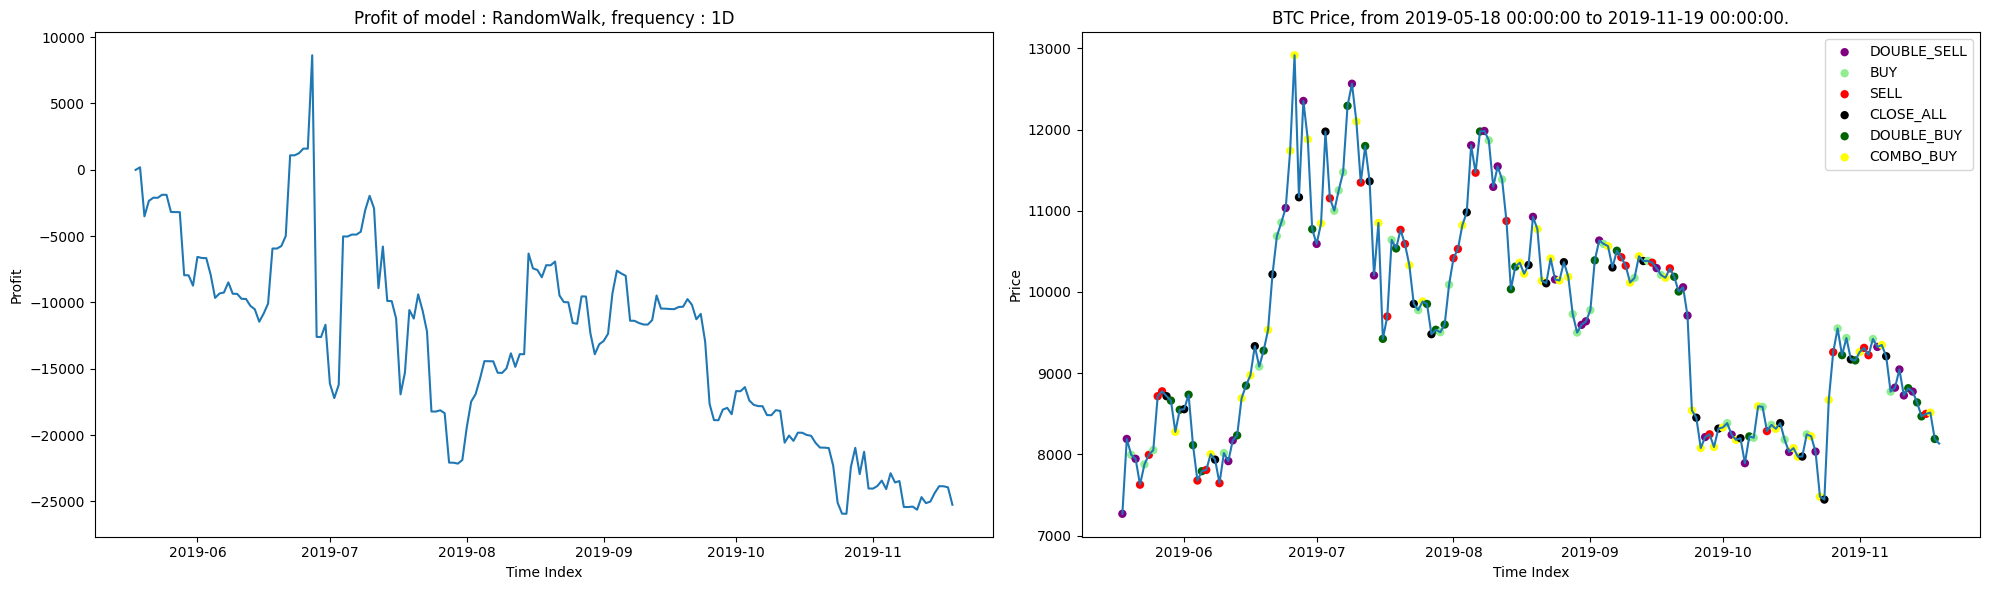

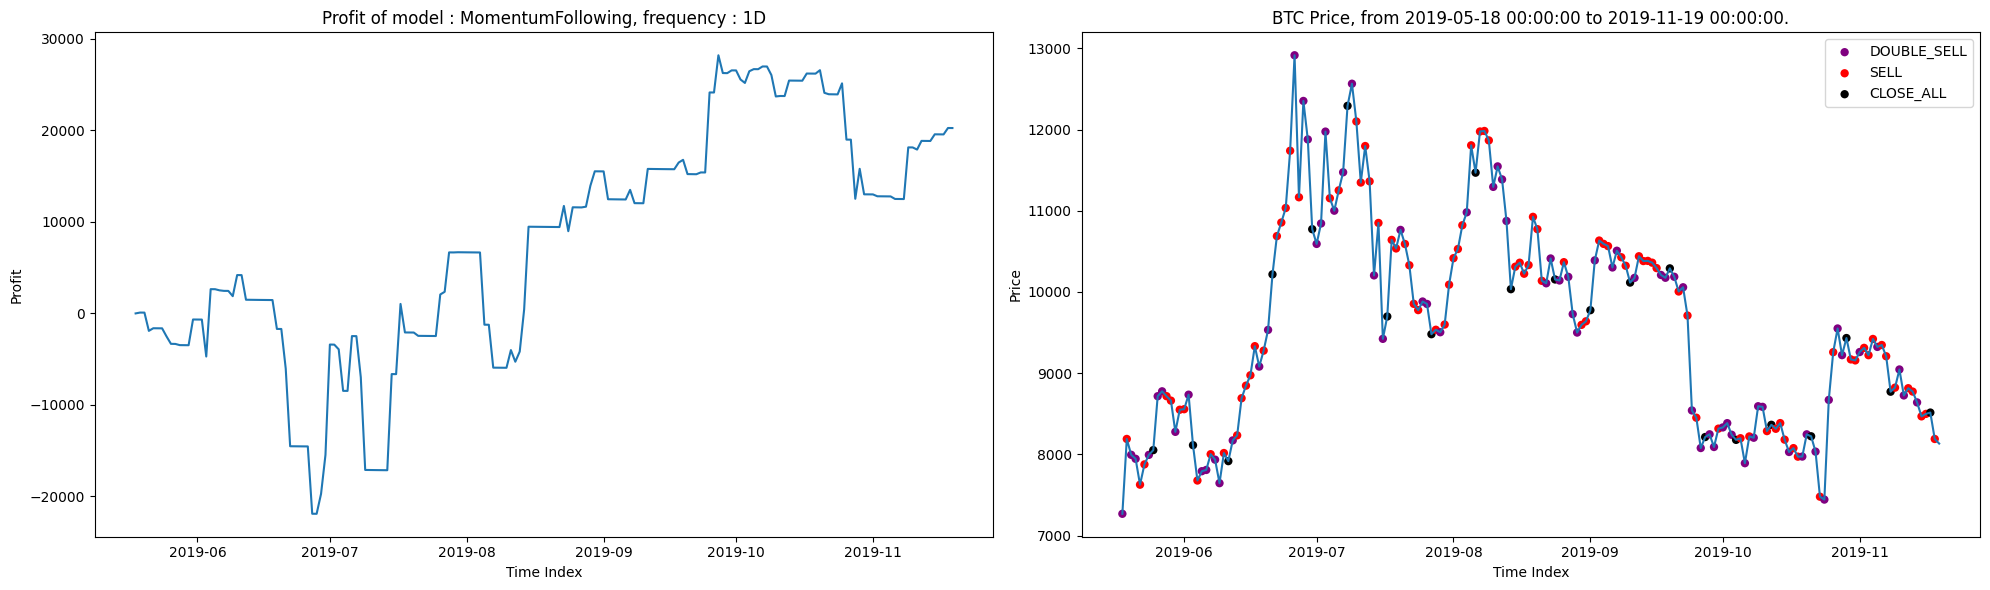

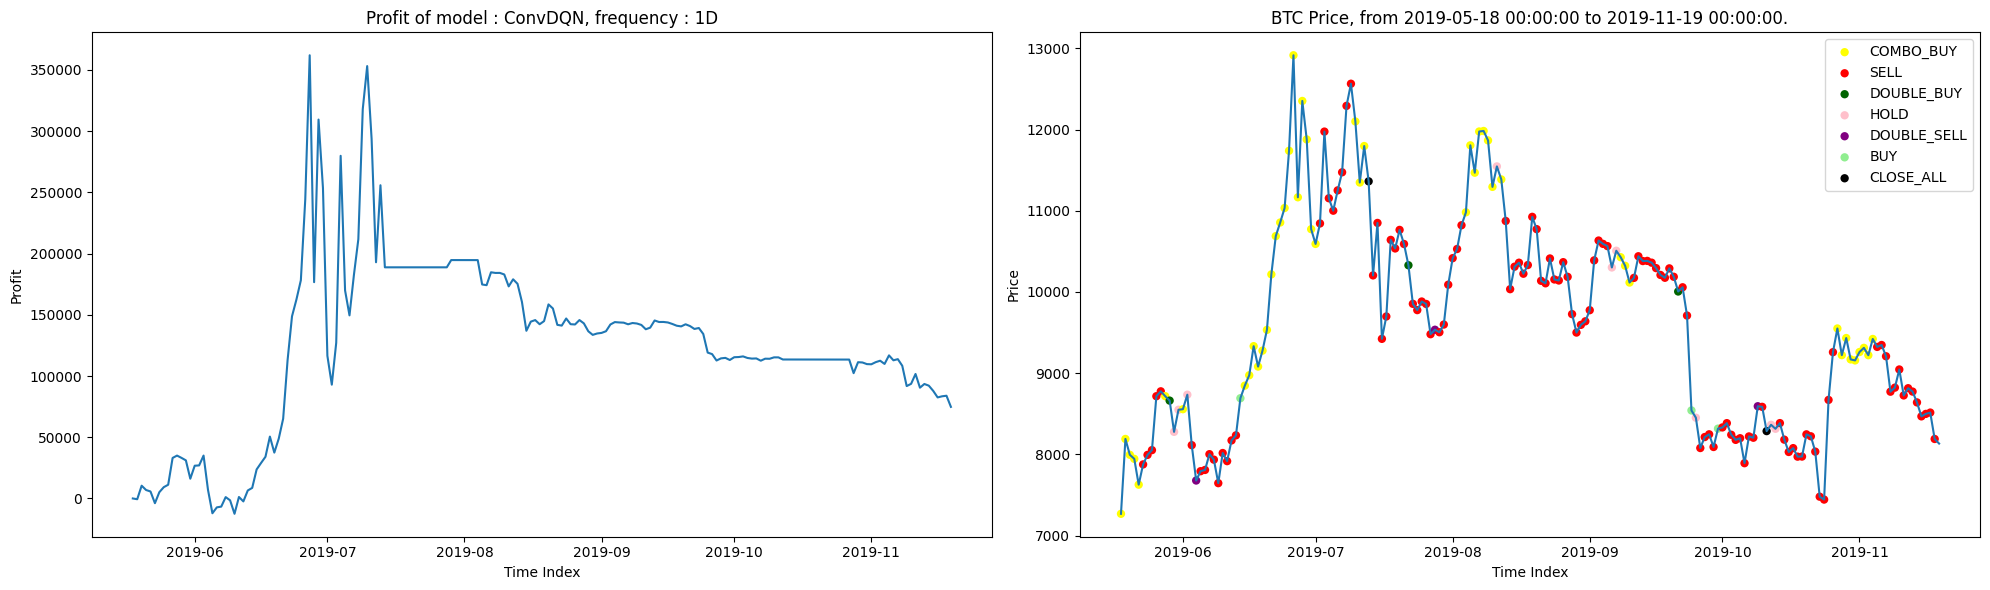

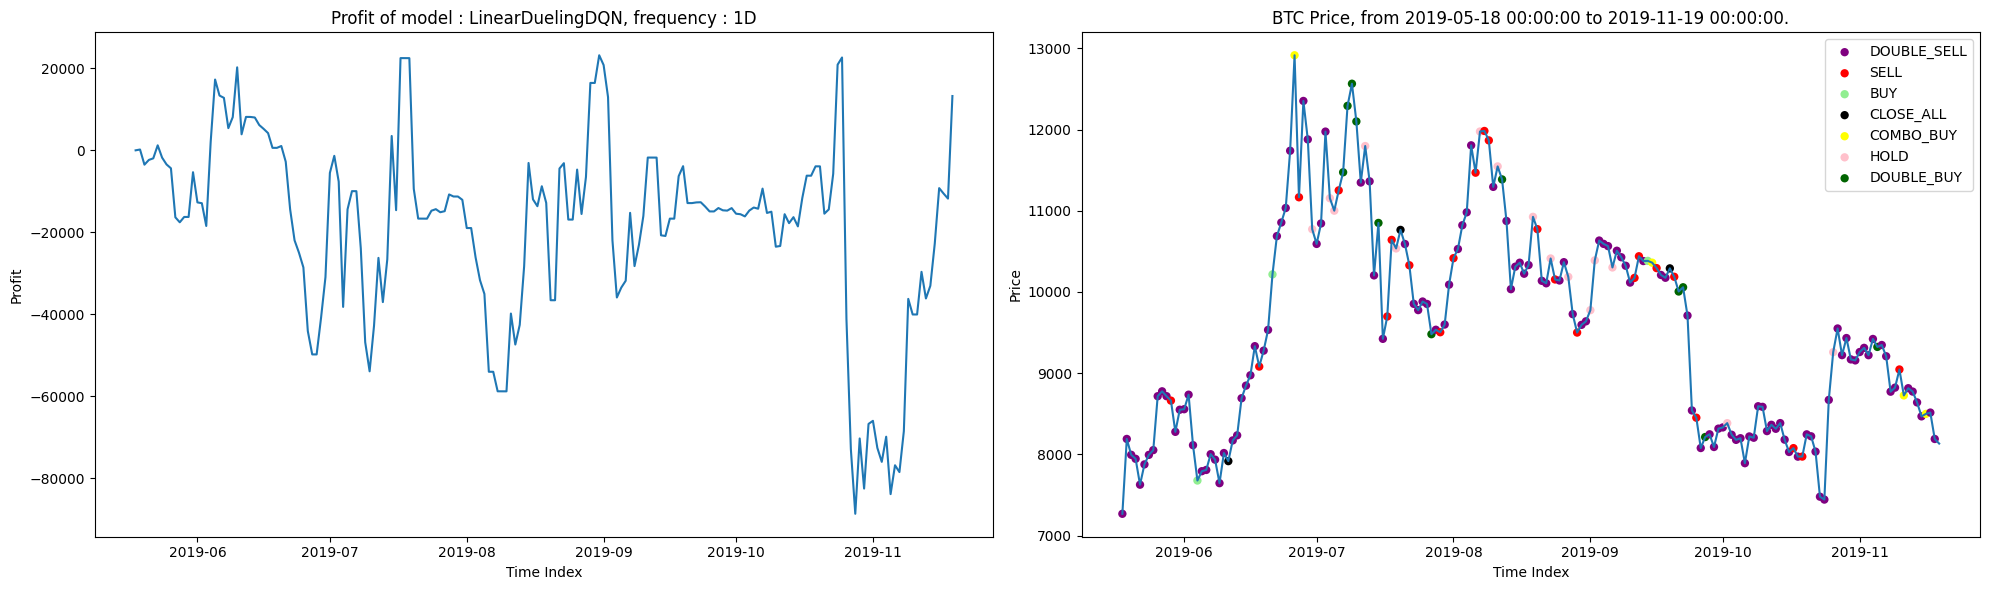

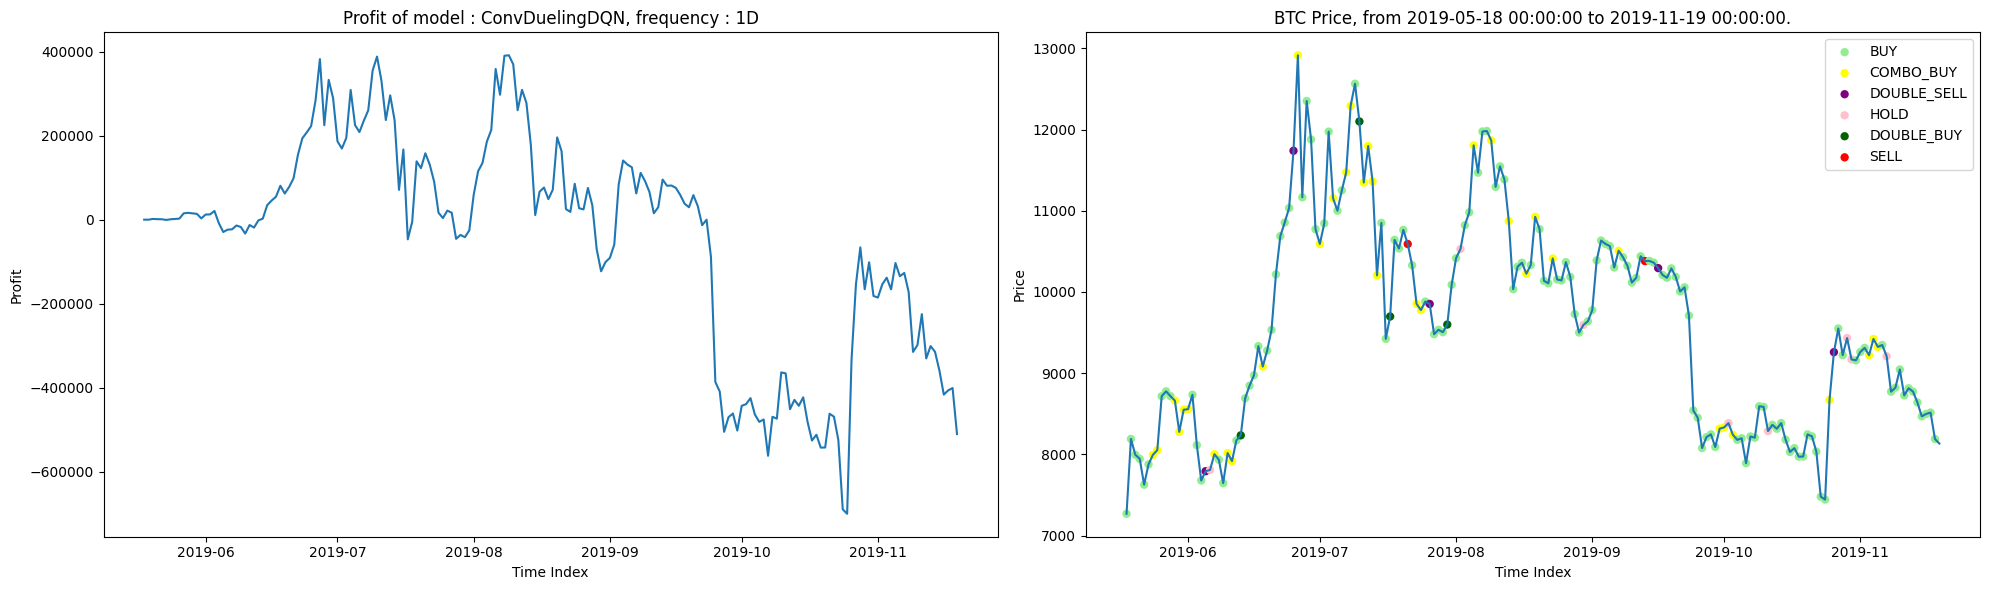

In [181]:
agent_result = Agent_Visualization(main_dic)

for t in agent_result.time_freqs:
    for model in agent_result.models:
        agent_result.pnl_plot(t, model, atom_key='Profit', action_overlay=True)

In [182]:
sum_stats = {}
for t in agent_result.time_freqs:
    sum_stats[t] = {}
    for model in agent_result.models:
        sum_stats[t][model] = agent_result.summary_stats(t, model)

data_for_df = []
for t, models in sum_stats.items():
    for model, stats in models.items():
        row_data = {
            'time_freq': t, 
            'model': model, 
            'profit, $': stats[0], 
            'min_pos, $': stats[1], 
            'max_pos, $': stats[2], 
            'avg_pos, $': stats[3], 
            'std': stats[4], 
            'skewness': stats[5], 
            'kurto': stats[6]
        }
        data_for_df.append(row_data)

df = pd.DataFrame(data_for_df)

print(df)

   time_freq              model  profit, $  min_pos, $  max_pos, $  \
0       5MIN         RandomWalk   -2472.88    -2579.59       -5.00   
1       5MIN  MomentumFollowing   -1845.19    -1919.31      193.70   
2       5MIN            ConvDQN   -1494.78    -1494.78      241.97   
3       5MIN   LinearDuelingDQN     164.26    -2658.94     3899.05   
4       5MIN     ConvDuelingDQN    -665.06    -2208.30      335.53   
5      15MIN         RandomWalk   -2506.11    -2753.69      456.13   
6      15MIN  MomentumFollowing   -5658.37    -5658.37      135.64   
7      15MIN            ConvDQN   -4651.59    -5410.55      746.31   
8      15MIN   LinearDuelingDQN   -7891.10   -10407.15     2602.00   
9      15MIN     ConvDuelingDQN    6370.39    -1662.92    10267.58   
10        1H         RandomWalk   -2725.21    -2725.21      -10.00   
11        1H  MomentumFollowing   -3238.61    -3238.61       -5.00   
12        1H            ConvDQN   -2293.60    -2293.60       -5.00   
13        1H   Linea

In [184]:
profit_df = df[['time_freq', 'model', 'profit, $']]
df_sorted = profit_df.sort_values(by=['time_freq', 'profit, $'], ascending=[True, False])

#Grouping by timefreq then applying ranking
df_sorted['rank'] = df_sorted.groupby('time_freq')['profit, $'].rank(method='dense', ascending=False)

#Sorting first by time_freq then by rank
df_sorted = df_sorted.sort_values(by=['time_freq', 'rank'])

print(df_sorted)

   time_freq              model  profit, $  rank
9      15MIN     ConvDuelingDQN    6370.39   1.0
5      15MIN         RandomWalk   -2506.11   2.0
7      15MIN            ConvDQN   -4651.59   3.0
6      15MIN  MomentumFollowing   -5658.37   4.0
8      15MIN   LinearDuelingDQN   -7891.10   5.0
22        1D            ConvDQN   74797.19   1.0
21        1D  MomentumFollowing   20239.18   2.0
23        1D   LinearDuelingDQN   13234.87   3.0
20        1D         RandomWalk  -25251.51   4.0
24        1D     ConvDuelingDQN -510571.22   5.0
14        1H     ConvDuelingDQN   -2169.19   1.0
12        1H            ConvDQN   -2293.60   2.0
10        1H         RandomWalk   -2725.21   3.0
11        1H  MomentumFollowing   -3238.61   4.0
13        1H   LinearDuelingDQN   -4746.83   5.0
3       5MIN   LinearDuelingDQN     164.26   1.0
4       5MIN     ConvDuelingDQN    -665.06   2.0
2       5MIN            ConvDQN   -1494.78   3.0
1       5MIN  MomentumFollowing   -1845.19   4.0
0       5MIN        

/var/folders/99/0s8gtz5571vd84rgdljszgb80000gn/T/ipykernel_907/2399457042.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


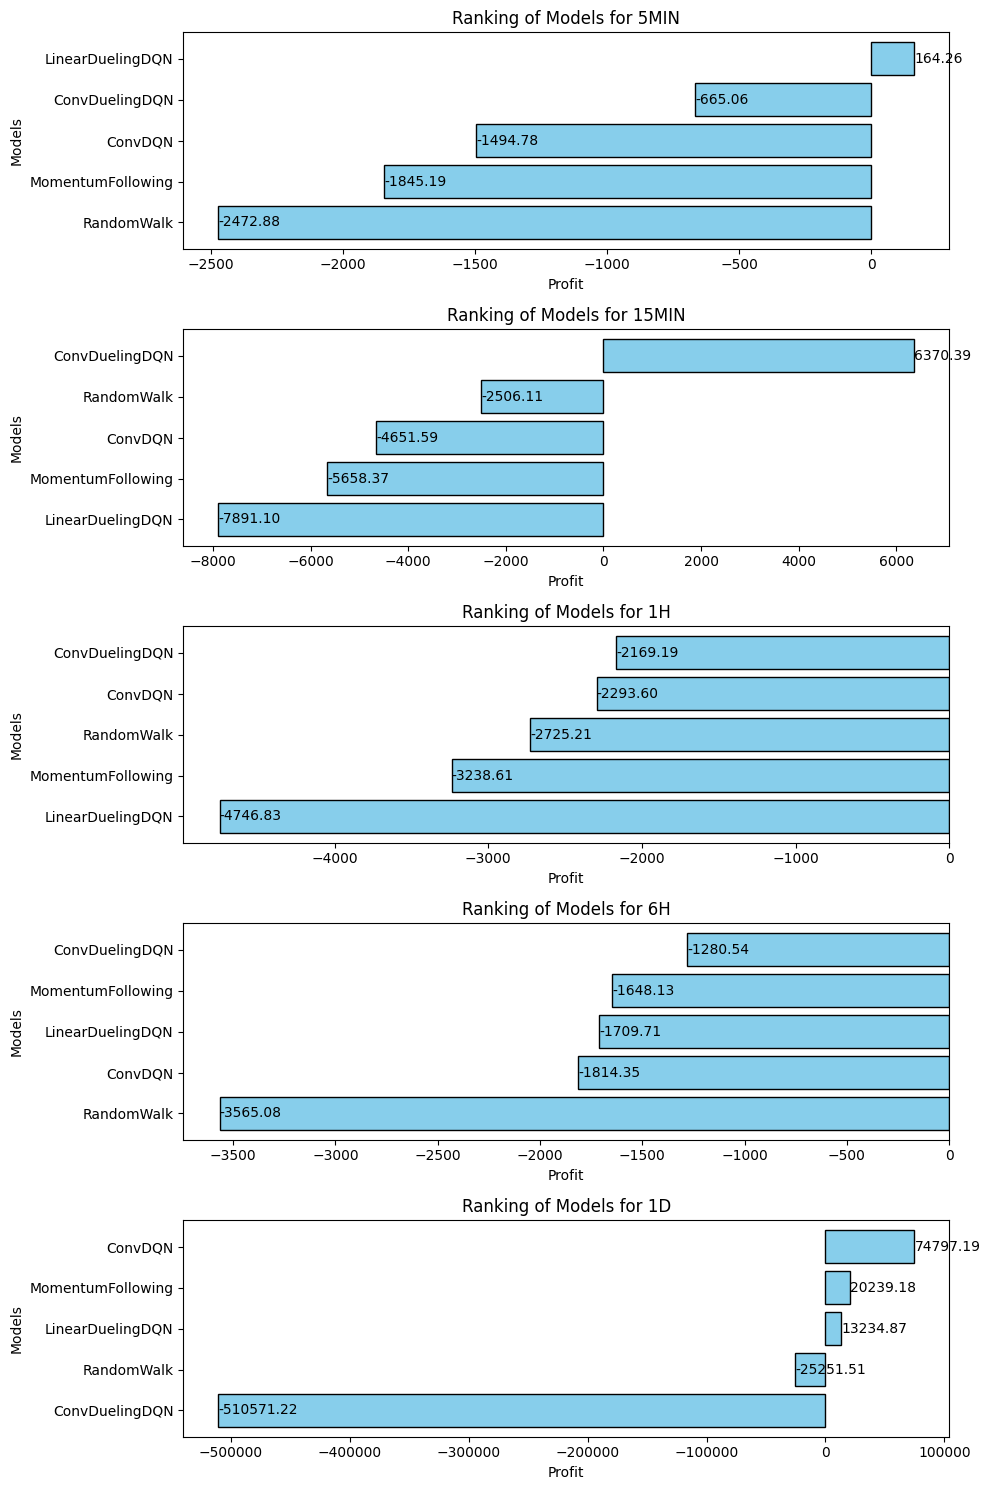

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_sorted is your DataFrame from the previous step that includes the 'rank' column

# We'll create a plot for each time_freq
# time_freqs = df_sorted['time_freq'].unique()
time_freqs = ['5MIN', '15MIN', '1H', '6H', '1D']

# Setting up the figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(time_freqs), ncols=1, figsize=(10, 15), constrained_layout=True)

# If there is only one time frequency, axs might not be an array, fix that:
if len(time_freqs) == 1:
    axs = [axs]

for ax, time_freq in zip(axs, time_freqs):
    # Filter the DataFrame for the current time_freq & sorting by rank 
    df_temp = df_sorted[df_sorted['time_freq'] == time_freq]
    df_temp = df_temp.sort_values(by='rank')
    
    # bar plot
    ax.barh(df_temp['model'], df_temp['profit'], color='skyblue', edgecolor='black')
    ax.set_title(f'Ranking of Models for {time_freq}')
    ax.set_xlabel('Profit')
    ax.set_ylabel('Models')
    ax.invert_yaxis()  # Invert y axis to have the highest rank on top
    
    # Adding profit values as text labels
    for index, value in enumerate(df_temp['profit']):
        ax.text(value, index, f'{value:.2f}', va='center')


plt.tight_layout()
plt.show()
